# Always Run

This sets up global variables that will be used throughout.

In [1]:
import os
import requests
from pathlib import Path
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)

windows_ouput_dir = Path('windows_models/output')

In [2]:
# Check which devices are available. We check for gpu and mps
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

platform = os.name

Using device: cuda


In [3]:
import importlib
import tarfile
import transform_utilities
import visualization_utilities
import gtzan_dataset
import models
import mtg_contrastive
import mtg_contrastive_mel
import infonce_loss
import barlow_twin_loss


# Reload Packages after Changes are made

In [4]:
importlib.reload(transform_utilities)
importlib.reload(visualization_utilities)
importlib.reload(gtzan_dataset)
importlib.reload(models)
importlib.reload(mtg_contrastive)
importlib.reload(mtg_contrastive_mel)
importlib.reload(infonce_loss)
importlib.reload(barlow_twin_loss)


from transform_utilities import *
from visualization_utilities import *
from gtzan_dataset import *
from models import *
from mtg_contrastive import MTGContrastiveDataset
from mtg_contrastive_mel import MTG_Mel_ContrastiveDataset, worker_init_fn
from infonce_loss import InfoNCE
from barlow_twin_loss import BarlowTwinsLoss



In [5]:
from pathlib import Path
from tqdm import tqdm
from torch.utils.data import dataloader
import numpy as np
import pickle
import shutil


In [6]:
p_test = 0.2
p_train_val = 1 - p_test

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [7]:
# Path for the deep model trained end to end on GTZAN
deep_base_output_dir = output_dir / 'base_gtzan'
deep_base_output_dir.mkdir(exist_ok=True)

# Define the path for the checkpoints for the pretrained contrastive model
contrastive_output_dir = output_dir / 'contrastive'
contrastive_output_dir.mkdir(exist_ok=True)

# Define the path for the checkpoints for the pretrained barlow model
barlow_contrastive_output_dir = output_dir / 'barlow_contrastive'
barlow_contrastive_output_dir.mkdir(exist_ok=True)

# Path for the mlp that accepts the embeddings (un-normalized) from the contrastive model
contrastive_classifier_output_dir = output_dir / 'contrastive_classifier'
contrastive_classifier_output_dir.mkdir(exist_ok=True)

# Path for the mlp that accepts the logits from the contrastive model
contrastive_classifier_embedder_only_output_dir = output_dir / 'contrastive_classifier_embedder_only'
contrastive_classifier_embedder_only_output_dir.mkdir(exist_ok=True)

# Path for the mlp that accepts the embeddings (normalized) from the barlow model
contrastive_classifier_barlow_output_dir = output_dir / 'contrastive_classifier_barlow'
contrastive_classifier_barlow_output_dir.mkdir(exist_ok=True)

# Path for the mlp that accepts the logits from the barlow model
contrastive_classifier_barlow_embedder_only_output_dir = output_dir / 'contrastive_classifier_barlow_embedder_only'
contrastive_classifier_barlow_embedder_only_output_dir.mkdir(exist_ok=True)

# Path for baseline random forest
baseline_random_forest_output_dir = output_dir / 'baseline_random_forest'
baseline_random_forest_output_dir.mkdir(exist_ok=True)

# Path for the random forest that uses contrastive embeddings
contrastive_random_forest_output_dir = output_dir / 'contrastive_random_forest'
contrastive_random_forest_output_dir.mkdir(exist_ok=True)



# GTZag Dataset
This is a 1000 file dataset with 10 genres represented. Each file is assigned to a single genre with no overlap. Each genre has exactly 100 files associated with it.

This makes it very easy to use, but it is rather small. If we have extra time, it may be good to evaluate on the larger MTG dataset anyways.

In [8]:
from pathlib import Path
import torchaudio
gtzan_dir = Path('./genres')
print(gtzan_dir.absolute().as_posix())
gtzan_dir.mkdir(parents=True, exist_ok=True)

dataset_tar_path = gtzan_dir / 'genres.tar.gz'
dataset_path = gtzan_dir / 'genres'

c:/Users/Sahib Mukker/Desktop/aps360_project_2024/genres


In [9]:
print(dataset_path)

genres\genres


In [10]:
# if not dataset_path.exists():
#     !wget "https://huggingface.co/datasets/marsyas/gtzan/resolve/main/data/genres.tar.gz?download=true" -O $dataset_tar_path
#     # This creates a /content/genres folder with subfolders for each genre
#     !tar -xf $dataset_tar_path -C $gtzan_dir

In [11]:
# if not dataset_path.exists():
#     print("Path Exists")
#     !tar -xf $dataset_tar_path -C $gtzan_dir

In [12]:
if not dataset_path.exists():
    url = "https://huggingface.co/datasets/marsyas/gtzan/resolve/main/data/genres.tar.gz?download=true"
    
    # Send a HEAD request to get the total file size for the progress bar
    response = requests.head(url)
    total_size = int(response.headers.get('content-length', 0))

    # Start the actual download
    with requests.get(url, stream=True) as response, open(dataset_tar_path, 'wb') as f, tqdm(
        total=total_size, unit='B', unit_scale=True, desc=dataset_tar_path.name
    ) as progress_bar:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
            progress_bar.update(len(chunk))

    # Extract the tar.gz file
    with tarfile.open(dataset_tar_path, "r:gz") as tar:
        tar.extractall(path=gtzan_dir)

In [13]:
references_sample_rate = 22050

In [14]:
reprocess_gtzan_dataset = True

In [15]:
if reprocess_gtzan_dataset:
    # Collect the waveforms into a dictionary of genre index to list of waveforms
    genre_folders = sorted(list(dataset_path.glob('[!.]*')))
    genres = [folder.name.split("/")[-1] for folder in genre_folders]
    genre_index_map = {genre: i for i, genre in enumerate(genres)}
    audio_tensors = {
        genre_index_map[genre]: [] for genre in genres
    }

    references_sample_rate = None
    for genre_folder in genre_folders:
        files = sorted(list(genre_folder.glob('[!.]*.wav')))
        # if platform == 'nt':
        #     genre = genre_index_map[genre_folder.name.split("\\")[-1]]
        # else:
        genre = genre_index_map[genre_folder.name.split("/")[-1]]

        print(f'Processing Genre {genre} with {len(files)} files')
        for file in files:
            try:
                waveform, sample_rate = torchaudio.load(file)
                if references_sample_rate is None:
                    print(f'Setting references_sample_rate to {sample_rate}')
                    references_sample_rate = sample_rate
                if sample_rate != references_sample_rate:
                    print(f'Resampling {file} from {sample_rate} to {references_sample_rate}')
                    waveform = torchaudio.functional.resample(waveform, sample_rate, references_sample_rate)
                audio_tensors[genre].append(waveform)
            except RuntimeError:
                print(f'Error loading {file}')

    # For each genre, select p_test of the waveforms to be in the test set
    np.random.seed(SEED)
    audio_tensors_test = {}
    for genre, tensors in audio_tensors.items():
        n = len(tensors)
        n_test = int(n * p_test)
        test_indices = np.random.choice(n, n_test, replace=False)
        audio_tensors_test[genre] = [tensors[i] for i in range(n) if i in test_indices]
        audio_tensors[genre] = [tensors[i] for i in range(n) if i not in test_indices]

Processing Genre 0 with 100 files
Setting references_sample_rate to 22050


Processing Genre 1 with 100 files
Processing Genre 2 with 100 files
Processing Genre 3 with 100 files
Processing Genre 4 with 100 files
Processing Genre 5 with 100 files
Error loading genres\genres\jazz\jazz.00054.wav
Processing Genre 6 with 100 files
Processing Genre 7 with 100 files
Processing Genre 8 with 100 files
Processing Genre 9 with 100 files


Genre: classical
Sample: 3


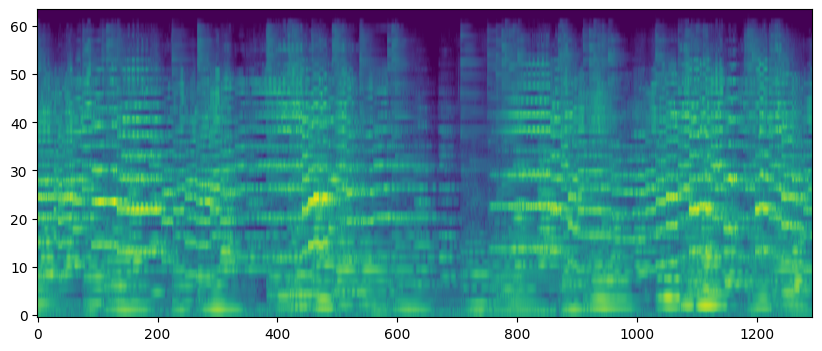

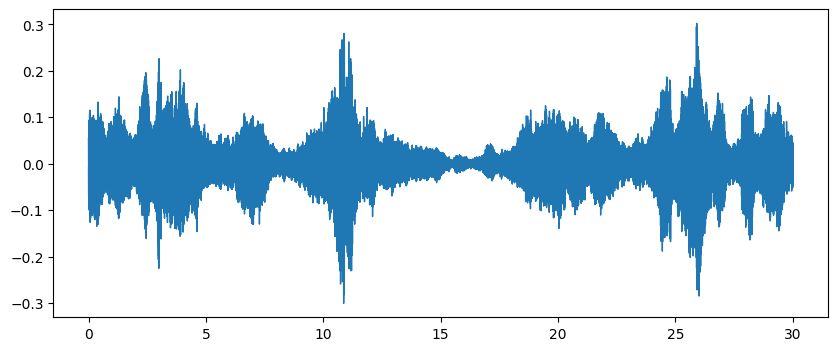

In [16]:
test_genre = 1
test_sample = 3

print(f"Genre: {genres[test_genre]}")
print(f"Sample: {test_sample}")

test_mel = get_mel_spectrogram(audio_tensors[test_genre][test_sample], references_sample_rate)
visualize_mel_spectrogram(test_mel)

test_waveform = visualize_waveform(audio_tensors[test_genre][test_sample], references_sample_rate)

In [17]:
ds = GTZANDataset(audio_tensors, genres, genre_index_map, references_sample_rate, mask_prob=0)
print(f"Dataset size: {len(ds)}")

Dataset size: 800


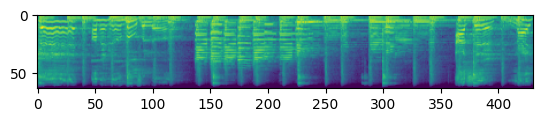

In [18]:
plt.imshow(ds[0][1].squeeze(0))
plt.show()

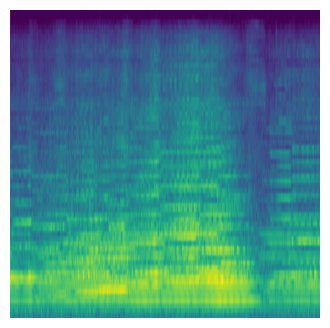

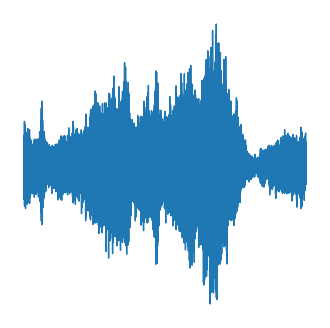

Genre: classical


In [19]:
from IPython.display import display, Audio
from ipywidgets import interactive

waveform, mel_spectrogram, label = ds[106]
# waveform, mel_spectrogram, label = ds[]
visualize_mel_spectrogram(mel_spectrogram, width=4, show_axes=False)
visualize_waveform(waveform, references_sample_rate, width=4, show_axes=False)
print(f"Genre: {genres[label]}")

display(Audio(waveform, rate=references_sample_rate))

# MTG Dataset

In [20]:
# Clone the github if it is not present
mtg_github_path = Path('mtg_github')
if not mtg_github_path.exists():
    !git clone https://github.com/MTG/mtg-jamendo-dataset.git mtg_github

In [21]:
# Load the mtg dataset
mtg_path = Path('') / 'mtg'
mtg_path.mkdir(exist_ok=True)

num_folders = 21

In [22]:
# Modified from the mtg github scripts/download.py

import os
import csv
import requests
import tempfile
import shutil
import hashlib
import tarfile
import sys
from tqdm import tqdm


mtg_base_path = mtg_github_path
ID_FILE_PATH = (mtg_base_path / "data/download/").resolve()

download_from_names = {'gdrive': 'GDrive', 'mtg': 'MTG', 'mtg-fast': 'MTG Fast mirror'}

CHUNK_SIZE = 512 * 1024  # 512KB


def compute_sha256(filename):
    with open(filename, 'rb') as f:
        contents = f.read()
        checksum = hashlib.sha256(contents).hexdigest()
        return checksum


def download_from_mtg(url, output):
    output_path = Path(output)

    print('Downloading...', file=sys.stderr)
    print('From:', url, file=sys.stderr)
    print('To:', output_path, file=sys.stderr)

    res = requests.get(url, stream=True)

    try:
        total = res.headers.get('Content-Length')
        if total is not None:
            total = int(total)
        with tempfile.NamedTemporaryFile(
            prefix=output_path.name,
            dir=output_path.parent,
            delete=False,
        ) as tmp_file_d:
            tmp_file = tmp_file_d.name
            with tqdm(total=total, unit='B', unit_scale=True) as progressbar:
                for chunk in res.iter_content(chunk_size=CHUNK_SIZE):
                    tmp_file_d.write(chunk)
                    progressbar.update(len(chunk))
        shutil.move(tmp_file_d.name, output)
    finally:
        try:
            os.remove(tmp_file)
        except OSError:
            pass

    return output


def download(dataset, data_type, download_from, output_dir, unpack_tars, remove_tars, tar_limit=None):
    if not os.path.exists(output_dir):
        print('Output directory {} does not exist'.format(output_dir), file=sys.stderr)
        return
    # Get the number of folders already in the output directory.
    output_dir = Path(output_dir)
    existing_folders = [f for f in output_dir.iterdir() if f.is_dir()]
    num_folders = len(existing_folders)

    if download_from not in download_from_names:
        print("Unknown --from argument, choices are {}".format(list(download_from_names.keys())), file=sys.stderr)
        return

    print('Downloading %s from %s' % (dataset, download_from_names[download_from]))
    file_gids = os.path.join(ID_FILE_PATH, dataset + '_' + data_type + '_gids.txt')
    file_sha256_tars = os.path.join(ID_FILE_PATH, dataset + '_' + data_type + '_sha256_tars.txt')
    file_sha256_tracks = os.path.join(ID_FILE_PATH, dataset + '_' + data_type + '_sha256_tracks.txt')

    # Read checksum values for tars and files inside.
    with open(file_sha256_tars) as f:
        sha256_tars = dict([(row[1], row[0]) for row in csv.reader(f, delimiter=' ')])

    with open(file_sha256_tracks) as f:
        sha256_tracks = dict([(row[1], row[0]) for row in csv.reader(f, delimiter=' ')])

    # Filenames to download.
    ids = sha256_tars.keys()

    # Google IDs to download.
    if download_from == 'gdrive':
        gids = {}
        with open(file_gids, 'r') as f:
            for line in f:
                id, filename = line.split(('   '))[:2]
                gids[filename] = id

    removed = []
    ids = list(ids)[:tar_limit] if tar_limit else list(ids)
    ids = ids[num_folders:]
    for filename in ids:
        output = os.path.join(output_dir, filename)

        # Download from Google Drive.
        if os.path.exists(output):
            print('Skipping %s (file already exists)' % output)
            continue

        if download_from == 'gdrive':
            url = 'https://drive.google.com/uc?id=%s' % gids[filename]
            gdown.download(url, output, quiet=False)

        elif download_from == 'mtg':
            url = 'https://essentia.upf.edu/documentation/datasets/mtg-jamendo/' \
                  '%s/%s/%s' % (dataset, data_type, filename)
            download_from_mtg(url, output)

        elif download_from == 'mtg-fast':
            url = 'https://cdn.freesound.org/mtg-jamendo/' \
                  '%s/%s/%s' % (dataset, data_type, filename)
            download_from_mtg(url, output)

        # Validate the checksum.
        if compute_sha256(output) != sha256_tars[filename]:
            print('%s does not match the checksum, removing the file' % output, file=sys.stderr)
            removed.append(filename)
            os.remove(output)
        else:
            print('%s checksum OK' % filename)

    if removed:
        print('Missing files:', ' '.join(removed))
        print('Re-run the script again')
        return

    print('Download complete')

    if unpack_tars:
        print('Unpacking tar archives')

        tracks_checked = []
        for filename in ids:
            output = os.path.join(output_dir, filename)
            print('Unpacking', output)
            tar = tarfile.open(output)
            tracks = tar.getnames()[1:]  # The first element is folder name.
            tar.extractall(path=output_dir)
            tar.close()

            # Validate checksums for all unpacked files
            for track in tracks:
                trackname = os.path.join(output_dir, track)
                if compute_sha256(trackname) != sha256_tracks[track]:
                    print('%s does not match the checksum' % trackname, file=sys.stderr)
                    raise Exception('Corrupt file in the dataset: %s' % trackname)

            print('%s track checksums OK' % filename)
            tracks_checked += tracks

            if remove_tars:
                os.remove(output)

        print('Unpacking complete')

In [23]:
# download('raw_30s', 'audio-low', 'mtg-fast', mtg_path, unpack_tars=True, remove_tars=True, tar_limit=num_folders)

In [24]:
# download('raw_30s', 'melspecs', 'mtg-fast', mtg_melspecs_path, unpack_tars=True, remove_tars=True, tar_limit=1)

In [25]:
mtg_mel_path = mtg_path = Path('') / 'mtg_mel'
mtg_dataset = MTG_Mel_ContrastiveDataset(mtg_mel_path, references_sample_rate, mask_prob=0)
print(f"Dataset size: {len(mtg_dataset)}")

Dataset size: 114250


# High Level Classifier Training Loop

This loop is used for training all convolutional and mlp classifiers so we keep it separated.

In [26]:
def train_base_gtzan_classifier(model, train_loader, val_loader, epochs, learning_rate, output_dir: Path):
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=epochs)

    t_loss_history = []
    v_loss_history = []
    v_acc_history = []

    step = 0
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()

        for (waveform, mel_spectrogram, label) in tqdm(train_loader):
            mel_spectrogram = mel_spectrogram.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            output = model(mel_spectrogram)
            loss = criterion(output, label)
            t_loss_history.append((step, loss.item()))
            loss.backward()
            optimizer.step()
            scheduler.step()
            step += 1

        model.eval()

        with torch.no_grad():
            val_losses = []
            val_accuracies = []
            for (waveform, mel_spectrogram, label) in val_loader:
                mel_spectrogram = mel_spectrogram.to(device)
                label = label.to(device)

                output = model(mel_spectrogram)
                val_loss = criterion(output, label)
                val_losses.append(val_loss.item())
                val_acc = (output.argmax(dim=1) == label).float().mean()
                val_accuracies.append(val_acc.item())

            val_loss = torch.tensor(val_losses).mean()
            v_loss_history.append((step, val_loss.item()))
            val_acc = torch.tensor(val_accuracies).mean()
            v_acc_history.append((step, val_acc.item()))

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), output_dir / 'best.pth')

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | Val Acc: {val_acc.item():.4f}")

    return t_loss_history, v_loss_history, v_acc_history

# Deep Convolutional Classifier
This section defines the model and training loop for the deep architecture. It is trained end to end on the GTZAN dataset with no input from the MTG dataset.

In [ ]:
%%skip

np.random.seed(SEED)
torch.manual_seed(SEED)

# Create a figure for the losses
loss_fig, loss_axs = plt.subplots(1, 1, figsize=(10, 5))

# Create a figure for the accuracies
acc_fig, acc_axs = plt.subplots(1, 1, figsize=(10, 5))

t_loss_collection = []
v_loss_collection = []
v_acc_collection = []
print("Training base GTZAN classifier")
overwriting_cnn = False
for train_dataset, val_dataset in gtzan_generate_folds(audio_tensors, genres, references_sample_rate, mask_prob=0.8):
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    base_gtzan_model = GTZANModel(len(audio_tensors))
    base_gtzan_model = base_gtzan_model.to(device)

    fold_output_dir = deep_base_output_dir / f'fold_{len(t_loss_collection)}'
    fold_output_dir.mkdir(exist_ok=True)

    model_exists = (fold_output_dir / 'best.pth').exists()
    if model_exists and not overwriting_cnn:
        res = input("CNN model exists. Enter y to overwrite: ")
        if res.lower() != 'y':
            raise Exception("Model exists")
        else:
            overwriting_cnn = True


    t_loss, v_loss, v_acc = train_base_gtzan_classifier(base_gtzan_model, train_loader, val_loader, epochs=100, learning_rate=0.001, output_dir=fold_output_dir)
    t_loss_collection.append(t_loss)
    v_loss_collection.append(v_loss)
    v_acc_collection.append(v_acc)
    loss_axs.plot(*zip(*t_loss), label=f'Training Loss - Fold {len(t_loss_collection)}')
    loss_axs.plot(*zip(*v_loss), label=f'Validation Loss - Fold {len(v_loss_collection)}')
    acc_axs.plot(*zip(*v_acc), label=f'Validation Accuracy - Fold {len(v_acc_collection)}')

loss_axs.legend()
acc_axs.legend()

best_val_acc = max(v_acc, key=lambda x: x[1])[1]
print(f"Best validation accuracy: {best_val_acc:.4f}")

plt.show()

In [ ]:
%%skip
t_loss_collection_np = np.array([list(zip(*t_loss))[1] for t_loss in t_loss_collection])
avg_t_loss_np = np.mean(t_loss_collection_np, axis=0)
max_t_loss_np = np.max(t_loss_collection_np, axis=0)
min_t_loss_np = np.min(t_loss_collection_np, axis=0)
t_xs = np.arange(len(avg_t_loss_np))

v_loss_collection_np = np.array([list(zip(*v_loss))[1] for v_loss in v_loss_collection])
avg_v_loss_np = np.mean(v_loss_collection_np, axis=0)
max_v_loss_np = np.max(v_loss_collection_np, axis=0)
min_v_loss_np = np.min(v_loss_collection_np, axis=0)
v_xs = np.array(list(zip(*v_loss_collection[0]))[0])

In [ ]:
%%skip
# Plot the max, min, and average training losses
avg_loss_fig, avg_loss_axs = plt.subplots(1, 1, figsize=(10, 5))
avg_loss_axs.plot(avg_t_loss_np, label='Average Training Loss')
avg_loss_axs.fill_between(t_xs, min_t_loss_np, max_t_loss_np, alpha=0.2)

avg_loss_axs.plot(v_xs, avg_v_loss_np, label='Average Validation Loss')
avg_loss_axs.fill_between(v_xs, min_v_loss_np, max_v_loss_np, alpha=0.2)

avg_loss_axs.legend()
avg_loss_axs.set_xlabel('Step')
avg_loss_axs.set_ylabel('Cross Entropy Loss')
plt.show()


In [ ]:
%%skip
v_acc_collection_np = np.array([list(zip(*v_acc))[1] for v_acc in v_acc_collection])
avg_v_acc_np = np.mean(v_acc_collection_np, axis=0)
max_v_acc_np = np.max(v_acc_collection_np, axis=0)
min_v_acc_np = np.min(v_acc_collection_np, axis=0)

In [ ]:
%%skip
avg_acc_fig, avg_acc_axs = plt.subplots(1, 1, figsize=(10, 5))
avg_acc_axs.plot(v_xs, avg_v_acc_np, label='Average Validation Accuracy')
avg_acc_axs.fill_between(v_xs, min_v_acc_np, max_v_acc_np, alpha=0.2)
avg_acc_axs.legend()
avg_acc_axs.set_xlabel('Step')
avg_acc_axs.set_ylabel('Accuracy')
plt.show()

In [ ]:
%%skip
avg_deep_acc = avg_v_acc_np[-1]
std_deep_acc = np.std(v_acc_collection_np, axis=0)[-1]
print(f"Average validation accuracy over folds: {avg_deep_acc:.4f} +/- {std_deep_acc:.4f}")

# Contrastive Pretraining
This section defines the model and training loop for the contrastive pretraining. The contrastive model is trained entirely on the MTG dataset with no input from GTZAN. It then defines two MLP models that take in outputs of the contrastive model to classify the genre which are both trained on the GTZAN dataset. The first takes unnormalized embeddings from the contrastive model. However, in contrastive learning, the contrastive space has a reduced dimension due to the contrastive loss being more effective in lower dimensions. For use in downstream models, it is often suggested to use the previous layer before we project into the contrastive space, the logits. Therefore, we train a second MLP to use these logits to classify the genre.

In [ ]:
%%skip
%%script echo "Skipping"

import time
from IPython.display import display, Audio
mtg_ds = MTGContrastiveDataset(
    mtg_path,
    references_sample_rate,
    mask_prob=0.8, samples_per_file=30, folder_whitelist=['00', '01', '02', '03'], max_files=1100, concurrent_files=32
)
# Take a test sample
print(f"Dataset size: {len(mtg_ds)} (From {len(mtg_ds.all_files)} files)")
count = 0
for (wf1, wf2), (mel1, mel2), _ in mtg_ds:
    if count < 4:
        start_time = time.time() if count == 0 else start_time
        print(f"Audio {count}")
        # visualize_mel_spectrogram(mel1, width=4, show_axes=False)
        # visualize_mel_spectrogram(mel2, width=4, show_axes=False)
        # Play the audio
        display(Audio(wf1, rate=references_sample_rate))
        display(Audio(wf2, rate=references_sample_rate))
        full_wf = torch.cat((wf1, wf2), dim=1)
        display(Audio(full_wf, rate=references_sample_rate))
    if count > 1000:
        end_time = time.time()
        break
    count += 1
print(f"Time Per Sample: {(end_time - start_time) / (count-1):.4f}")

# Run the test again with a dataloader with n workers
from torch.utils.data import DataLoader
mtg_dl = DataLoader(mtg_ds, batch_size=32, num_workers=2, prefetch_factor=4, worker_init_fn=worker_init_fn)
count = 0
for (wf1, wf2), (mel1, mel2), _ in mtg_dl:
    if count == 0:
        start_time = time.time() if count == 0 else start_time
        for i in range(10):
            # Play the audio
            print(f"Audio {count+i}")
            display(Audio(wf1[i], rate=references_sample_rate))
            display(Audio(wf2[i], rate=references_sample_rate))
            full_wf = torch.cat((wf1[i], wf2[i]), dim=1)
            display(Audio(full_wf, rate=references_sample_rate))
    if count > 5000:
        end_time = time.time()
        break
    count += mel1.shape[0]
    print(f"Count: {count}")
print(f"Time Per Sample: {(end_time - start_time) / (count-1):.4f}")

In [27]:
def get_model_name(model_name, lr, batch_size):
    return f"{model_name}_LR({lr})_BS({batch_size})"

def train_contrastive_model(model, train_loader, val_loader, epochs, lr, batch_size, criterion, output_dir: Path, t_loss_history=None, v_loss_history=None, checkpoint_file=None, device = None):
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    criterion = criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)

    t_loss_history = [] if t_loss_history is None else t_loss_history
    v_loss_history = [] if v_loss_history is None else v_loss_history

    step = 0
    best_val_loss = np.inf

    if checkpoint_file is not None:
        print(f"Recovering model from {checkpoint_file}")
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scheduler.load_state_dict(checkpoint["scheduler"])
        step = checkpoint["step"]
        best_val_loss = checkpoint["best_val_loss"]
        recovered_epoch = checkpoint["epoch"]
        recovered_t_loss_history = checkpoint["t_loss_history"]
        recovered_v_loss_history = checkpoint["v_loss_history"]

        print(f"Recovered model from epoch {recovered_epoch} with best val loss {best_val_loss:.4f}")

        # Copy the recovered loss histories into the current ones
        t_loss_history.extend(recovered_t_loss_history)
        v_loss_history.extend(recovered_v_loss_history)
    else:
        recovered_epoch = 0

    for epoch in range(recovered_epoch, epochs):
        model.train()

        train_losses = []
        for (waveform1, waveform2), (mel_spectrogram1, mel_spectrogram2), label in tqdm(train_loader):
            
            mel_spectrogram1 = mel_spectrogram1.to(device)
            mel_spectrogram2 = mel_spectrogram2.to(device)
            mel_spectrogram = [mel_spectrogram1, mel_spectrogram2]
            # Stack the spectrograms along the batch dimension
            # mel_spectrogram = torch.cat([mel_spectrogram1, mel_spectrogram2], dim=0)

            # print(mel_spectrogram.shape)

            optimizer.zero_grad()
            output = model(mel_spectrogram)

            # Split the output into the original batches
            # output1, output2 = torch.split(output, output.shape[0] // 2, dim=0)

            loss = criterion(output)
            t_loss_history.append((step, loss.item()))
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step()
            step += 1
        avg_train_loss = torch.tensor(train_losses).mean()

        model.eval()
        # print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss.item():.4f}")
        with torch.no_grad():
            val_losses = []
            val_accuracies = []
            for (waveform1, waveform2), (mel_spectrogram1, mel_spectrogram2), label in tqdm(val_loader):
                mel_spectrogram1 = mel_spectrogram1.to(device)
                mel_spectrogram2 = mel_spectrogram2.to(device)
                mel_spectrogram = [mel_spectrogram1, mel_spectrogram2]
                
                output = model(mel_spectrogram)

                # output1, output2 = torch.split(output, output.shape[0] // 2, dim=0)
                val_loss = criterion(output)
                val_losses.append(val_loss.item())

            val_loss = torch.tensor(val_losses).mean()
            v_loss_history.append((step, val_loss.item()))

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), output_dir / f"{get_model_name(model.name, lr, batch_size)}_best.pth")

            # Save the latest model
            save_data = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "step": step,
                "epoch": epoch + 1,
                "best_val_loss": best_val_loss,
                "t_loss_history": t_loss_history,
                "v_loss_history": v_loss_history
            }
            torch.save(save_data, output_dir / f"{get_model_name(model.name, lr, batch_size)}_latest_checkpoint.pth")
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

    return t_loss_history, v_loss_history

            

In [ ]:
%%skip
np.random.seed(SEED)
torch.manual_seed(SEED)

batch_size = 64

# Using the MTG Dataset
train_folders = [
    "00", "01", "02", "03",
    "04", "05", "06", "07",
    "08", "09", "10", "11",
    "12", "13", "14", "15",
    "16", "17", "18", "19"
]
val_folders = [
    "20"
]
mtg_train_dataset = MTGContrastiveDataset(mtg_path, references_sample_rate, mask_prob=0.8, samples_per_file=15, folder_whitelist=train_folders, concurrent_files=batch_size)
mtg_val_dataset = MTGContrastiveDataset(mtg_path, references_sample_rate, mask_prob=0.8, samples_per_file=15, folder_whitelist=val_folders, max_files=2*batch_size, concurrent_files=batch_size)

train_loader = DataLoader(mtg_train_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=2)
val_loader = DataLoader(mtg_val_dataset, batch_size=batch_size, shuffle=False)

contrastive_embedder_model = GTZANContrastiveModelLarge(128)
contrastive_embedder_model = contrastive_embedder_model.to(device)

USE_LATEST_CHECKPOINT = True
checkpoint_file = contrastive_output_dir / 'latest_checkpoint.pth' if USE_LATEST_CHECKPOINT else None
if checkpoint_file is not None and not checkpoint_file.exists():
    print(f"Checkpoint file {checkpoint_file} not found, starting with a fresh model")
    checkpoint_file = None
else:
    print(f"Recovering model from {checkpoint_file}")

t_loss, v_loss = [], []
_ = train_contrastive_model(
    contrastive_embedder_model,
    train_loader, val_loader, epochs=25, lr=0.001, batch_size = batch_size, criterion = InfoNCE(),
    t_loss_history=t_loss, v_loss_history=v_loss,
    output_dir=contrastive_output_dir,
    checkpoint_file=checkpoint_file
)

# Barlow Twins Contrastive Pretraining 

In [28]:
def train_model_with_params(batch_size, learning_rate, epochs, criterion, model, output_dir):
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    batch_size = batch_size
    learning_rate = learning_rate

    # Using the MTG Dataset
    train_folders = [
        "00", "01", "02", "03",
        "04", "05", "06", "07",
        "08", "09", "10", "11",
        "12", "13", "14", "15",
        "16", "17", "18", "19"
    ]
    
    # train_folders = ["00"]
    
    val_folders = [
        "20"
    ]

    mtg_train_dataset = MTG_Mel_ContrastiveDataset(mtg_mel_path, references_sample_rate, mask_prob=0.8, samples_per_file=15, folder_whitelist=train_folders, concurrent_files=batch_size)
    mtg_val_dataset = MTG_Mel_ContrastiveDataset(mtg_mel_path, references_sample_rate, mask_prob=0.8, samples_per_file=15, folder_whitelist=val_folders, max_files=2*batch_size, concurrent_files=batch_size)

    train_loader = DataLoader(mtg_train_dataset, batch_size=batch_size, shuffle=False, num_workers=2, prefetch_factor=2)
    val_loader = DataLoader(mtg_val_dataset, batch_size=batch_size, shuffle=False)

    contrastive_embedder_model = model
    contrastive_embedder_model = contrastive_embedder_model.to(device)


    USE_LATEST_CHECKPOINT = True
    checkpoint_file = output_dir / f'{get_model_name(contrastive_embedder_model.name, learning_rate, batch_size)}_latest_checkpoint.pth' if USE_LATEST_CHECKPOINT else None
    if checkpoint_file is not None and not checkpoint_file.exists():
        print(f"Checkpoint file {checkpoint_file} not found, starting with a fresh model")
        checkpoint_file = None
    else:
        print(f"Recovering model from {checkpoint_file}")


    t_loss, v_loss = [], []
    _ = train_contrastive_model(
        contrastive_embedder_model,
        train_loader, val_loader, epochs=epochs, lr=learning_rate, batch_size=batch_size, criterion = criterion,
        t_loss_history=t_loss, v_loss_history=v_loss,
        output_dir=output_dir,
        checkpoint_file=checkpoint_file,
        device = device
    )
    
    losses = {'train_loss': t_loss, 'val_loss': v_loss}
    with open(output_dir / f'{get_model_name(contrastive_embedder_model.name, learning_rate, batch_size)}.pkl', 'wb') as file:
        pickle.dump(losses, file)
    return



In [29]:
def plot_losses(t_loss, v_loss):
    # Plot the losses
    contrastive_loss_fig, contrastive_loss_axs = plt.subplots(1, 1, figsize=(10, 5))
    contrastive_loss_axs.plot(*zip(*t_loss), label='Training Loss')
    contrastive_loss_axs.plot(*zip(*v_loss), label='Validation Loss')
    # contrastive_loss_axs.plot(*zip(*t_loss), label='Training Loss')
    contrastive_loss_axs.legend()
    contrastive_loss_axs.set_xlabel('Step')
    contrastive_loss_axs.set_ylabel('InfoNCE Loss')
    plt.show()

In [30]:
model = GTZANContrastiveModelXLarge(128)
criterion = InfoNCE()
output_dir = contrastive_output_dir
batch_size = 128
learning_rate = 0.001
epochs = 50
train_model_with_params(batch_size=batch_size, learning_rate=learning_rate, epochs = epochs, model=model, output_dir = output_dir, criterion = criterion )


Checkpoint file output\contrastive\GTZANContrastiveModelXLarge_CONT_DIM(128)_(3)_LR(0.001)_BS(128)_latest_checkpoint.pth not found, starting with a fresh model


  0%|          | 0/1276 [00:00<?, ?it/s]

In [30]:
def generate_gtzan_loaders(audio_tensors, genres, references_sample_rate, batch_size, mask_prob=0.8):
    # Return to the original dataset to train the classifier
    fold_generator = gtzan_generate_folds(audio_tensors, genres, references_sample_rate, mask_prob=0.8)
    train_dataset, val_dataset = next(fold_generator)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    return train_loader, val_loader

def train_classifier(embeddings_model, classification_model, num_classes,  train_loader, val_loader, epochs,embeddings_learning_rate, classifier_learning_rate, embeddings_batch_size,  classifier_batch_size, output_dir: Path):
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    # Load the best contrastive embedding model
    contrastive_embedder_model = embeddings_model(128)
    
    model_name = get_model_name(contrastive_embedder_model.name, embeddings_learning_rate, embeddings_batch_size)
    contrastive_embedder_model.load_state_dict(torch.load(output_dir / f'{model_name}_best.pth'))
    
    
    contrastive_classifier = classification_model(contrastive_embedder_model, num_classes)
    contrastive_classifier = contrastive_classifier.to(device)
    return train_base_gtzan_classifier(contrastive_classifier, train_loader, val_loader, epochs=epochs, learning_rate=classifier_learning_rate, output_dir=output_dir)

In [35]:
def plot_classifier_losses_accuracy(t_loss, v_loss, v_acc):
    # Plot the loss and accuracy
    contrastive_classifier_loss_fig, contrastive_classifier_loss_axs = plt.subplots(1, 1, figsize=(10, 5))
    contrastive_classifier_loss_axs.plot(*zip(*t_loss), label='Training Loss')
    contrastive_classifier_loss_axs.plot(*zip(*v_loss), label='Validation Loss')
    contrastive_classifier_loss_axs.legend()
    contrastive_classifier_loss_axs.set_xlabel('Step')
    contrastive_classifier_loss_axs.set_ylabel('Cross Entropy Loss')
    plt.show()

    contrastive_classifier_acc_fig, contrastive_classifier_acc_axs = plt.subplots(1, 1, figsize=(10, 5))
    contrastive_classifier_acc_axs.plot(*zip(*v_acc), label='Validation Accuracy')
    contrastive_classifier_acc_axs.legend()
    contrastive_classifier_acc_axs.set_xlabel('Step')
    contrastive_classifier_acc_axs.set_ylabel('Accuracy')
    plt.show()

C:\Users\Sahib Mukker\AppData\Local\Temp\ipykernel_14528\3831671036.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  contrastive_embedder_model.load_state_dict(torch.loa

Epoch 1/100 | Train Loss: 61.3986 | Val Loss: 89.6823 | Val Acc: 0.1562


100%|██████████| 20/20 [00:03<00:00,  5.47it/s]


Epoch 2/100 | Train Loss: 46.2177 | Val Loss: 71.6438 | Val Acc: 0.1625


100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Epoch 3/100 | Train Loss: 42.6222 | Val Loss: 53.8063 | Val Acc: 0.1875


100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Epoch 4/100 | Train Loss: 18.0962 | Val Loss: 40.1028 | Val Acc: 0.2688


100%|██████████| 20/20 [00:03<00:00,  5.56it/s]


Epoch 5/100 | Train Loss: 15.1516 | Val Loss: 29.2567 | Val Acc: 0.4000


100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


Epoch 6/100 | Train Loss: 16.6266 | Val Loss: 22.7799 | Val Acc: 0.4313


100%|██████████| 20/20 [00:03<00:00,  5.90it/s]


Epoch 7/100 | Train Loss: 11.8326 | Val Loss: 19.7140 | Val Acc: 0.4625


100%|██████████| 20/20 [00:03<00:00,  5.47it/s]


Epoch 8/100 | Train Loss: 6.4302 | Val Loss: 15.0544 | Val Acc: 0.5063


100%|██████████| 20/20 [00:03<00:00,  5.69it/s]


Epoch 9/100 | Train Loss: 7.8162 | Val Loss: 13.9356 | Val Acc: 0.5437


100%|██████████| 20/20 [00:03<00:00,  5.53it/s]


Epoch 10/100 | Train Loss: 12.7471 | Val Loss: 13.3195 | Val Acc: 0.5437


100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Epoch 11/100 | Train Loss: 6.7909 | Val Loss: 12.3646 | Val Acc: 0.5437


100%|██████████| 20/20 [00:03<00:00,  5.83it/s]


Epoch 12/100 | Train Loss: 3.5790 | Val Loss: 11.0213 | Val Acc: 0.6125


100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch 13/100 | Train Loss: 1.6761 | Val Loss: 11.5894 | Val Acc: 0.5750


100%|██████████| 20/20 [00:03<00:00,  5.70it/s]


Epoch 14/100 | Train Loss: 2.0667 | Val Loss: 11.1847 | Val Acc: 0.6375


100%|██████████| 20/20 [00:03<00:00,  5.65it/s]


Epoch 15/100 | Train Loss: 4.6249 | Val Loss: 10.9385 | Val Acc: 0.6375


100%|██████████| 20/20 [00:03<00:00,  5.69it/s]


Epoch 16/100 | Train Loss: 4.0111 | Val Loss: 9.6543 | Val Acc: 0.6250


100%|██████████| 20/20 [00:03<00:00,  5.55it/s]


Epoch 17/100 | Train Loss: 6.6512 | Val Loss: 10.5671 | Val Acc: 0.5938


100%|██████████| 20/20 [00:03<00:00,  5.95it/s]


Epoch 18/100 | Train Loss: 0.9826 | Val Loss: 9.4666 | Val Acc: 0.6375


100%|██████████| 20/20 [00:03<00:00,  5.85it/s]


Epoch 19/100 | Train Loss: 4.4805 | Val Loss: 10.4355 | Val Acc: 0.6250


100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Epoch 20/100 | Train Loss: 3.1225 | Val Loss: 9.7152 | Val Acc: 0.6625


100%|██████████| 20/20 [00:03<00:00,  5.90it/s]


Epoch 21/100 | Train Loss: 1.9202 | Val Loss: 9.9687 | Val Acc: 0.6313


100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Epoch 22/100 | Train Loss: 2.9005 | Val Loss: 9.8789 | Val Acc: 0.6375


100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


Epoch 23/100 | Train Loss: 2.9987 | Val Loss: 9.3645 | Val Acc: 0.6438


100%|██████████| 20/20 [00:03<00:00,  5.97it/s]


Epoch 24/100 | Train Loss: 1.6199 | Val Loss: 9.2938 | Val Acc: 0.6438


100%|██████████| 20/20 [00:03<00:00,  5.10it/s]


Epoch 25/100 | Train Loss: 1.6480 | Val Loss: 8.1915 | Val Acc: 0.7188


100%|██████████| 20/20 [00:03<00:00,  5.34it/s]


Epoch 26/100 | Train Loss: 1.5039 | Val Loss: 8.7049 | Val Acc: 0.6313


100%|██████████| 20/20 [00:03<00:00,  5.65it/s]


Epoch 27/100 | Train Loss: 0.6192 | Val Loss: 8.8886 | Val Acc: 0.7000


100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


Epoch 28/100 | Train Loss: 0.9155 | Val Loss: 9.7700 | Val Acc: 0.6625


100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


Epoch 29/100 | Train Loss: 2.6959 | Val Loss: 8.4979 | Val Acc: 0.6812


100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Epoch 30/100 | Train Loss: 2.3989 | Val Loss: 7.8866 | Val Acc: 0.6687


100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Epoch 31/100 | Train Loss: 2.2827 | Val Loss: 8.9966 | Val Acc: 0.6562


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Epoch 32/100 | Train Loss: 0.2806 | Val Loss: 10.2952 | Val Acc: 0.6500


100%|██████████| 20/20 [00:03<00:00,  5.95it/s]


Epoch 33/100 | Train Loss: 0.2153 | Val Loss: 8.4926 | Val Acc: 0.6875


100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Epoch 34/100 | Train Loss: 3.0757 | Val Loss: 8.3443 | Val Acc: 0.7063


100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch 35/100 | Train Loss: 0.2812 | Val Loss: 7.5543 | Val Acc: 0.6438


100%|██████████| 20/20 [00:03<00:00,  5.75it/s]


Epoch 36/100 | Train Loss: 0.8312 | Val Loss: 7.6412 | Val Acc: 0.6625


100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


Epoch 37/100 | Train Loss: 0.3522 | Val Loss: 8.4642 | Val Acc: 0.6375


100%|██████████| 20/20 [00:03<00:00,  5.95it/s]


Epoch 38/100 | Train Loss: 1.9412 | Val Loss: 8.3752 | Val Acc: 0.6313


100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch 39/100 | Train Loss: 3.5460 | Val Loss: 7.5870 | Val Acc: 0.6875


100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


Epoch 40/100 | Train Loss: 2.7866 | Val Loss: 8.6238 | Val Acc: 0.6750


100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Epoch 41/100 | Train Loss: 0.7638 | Val Loss: 8.1487 | Val Acc: 0.6625


100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


Epoch 42/100 | Train Loss: 0.4435 | Val Loss: 9.1558 | Val Acc: 0.6625


100%|██████████| 20/20 [00:03<00:00,  5.85it/s]


Epoch 43/100 | Train Loss: 1.5962 | Val Loss: 7.0192 | Val Acc: 0.6750


100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Epoch 44/100 | Train Loss: 1.6182 | Val Loss: 7.7832 | Val Acc: 0.6938


100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Epoch 45/100 | Train Loss: 1.1080 | Val Loss: 6.8944 | Val Acc: 0.6938


100%|██████████| 20/20 [00:03<00:00,  5.70it/s]


Epoch 46/100 | Train Loss: 0.3252 | Val Loss: 6.2830 | Val Acc: 0.6625


100%|██████████| 20/20 [00:03<00:00,  5.40it/s]


Epoch 47/100 | Train Loss: 0.8948 | Val Loss: 7.6512 | Val Acc: 0.6750


100%|██████████| 20/20 [00:03<00:00,  5.55it/s]


Epoch 48/100 | Train Loss: 0.8545 | Val Loss: 6.9687 | Val Acc: 0.6875


100%|██████████| 20/20 [00:03<00:00,  5.59it/s]


Epoch 49/100 | Train Loss: 0.1045 | Val Loss: 5.5368 | Val Acc: 0.7250


100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


Epoch 50/100 | Train Loss: 0.0674 | Val Loss: 5.9548 | Val Acc: 0.7375


100%|██████████| 20/20 [00:03<00:00,  5.90it/s]


Epoch 51/100 | Train Loss: 1.9799 | Val Loss: 6.1519 | Val Acc: 0.7000


100%|██████████| 20/20 [00:03<00:00,  5.97it/s]


Epoch 52/100 | Train Loss: 1.9092 | Val Loss: 6.9797 | Val Acc: 0.6938


100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Epoch 53/100 | Train Loss: 0.4929 | Val Loss: 7.6296 | Val Acc: 0.6938


100%|██████████| 20/20 [00:03<00:00,  5.83it/s]


Epoch 54/100 | Train Loss: 0.6064 | Val Loss: 7.1713 | Val Acc: 0.7125


100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


Epoch 55/100 | Train Loss: 0.0494 | Val Loss: 7.7601 | Val Acc: 0.6875


100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch 56/100 | Train Loss: 0.4329 | Val Loss: 7.7153 | Val Acc: 0.6750


100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Epoch 57/100 | Train Loss: 0.7308 | Val Loss: 6.8364 | Val Acc: 0.7000


100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Epoch 58/100 | Train Loss: 0.9991 | Val Loss: 5.7077 | Val Acc: 0.7312


100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Epoch 59/100 | Train Loss: 1.1186 | Val Loss: 6.5279 | Val Acc: 0.7063


100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch 60/100 | Train Loss: 0.1732 | Val Loss: 6.3318 | Val Acc: 0.7375


100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch 61/100 | Train Loss: 0.2685 | Val Loss: 6.5181 | Val Acc: 0.7000


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Epoch 62/100 | Train Loss: 0.5878 | Val Loss: 6.5237 | Val Acc: 0.7063


100%|██████████| 20/20 [00:03<00:00,  5.67it/s]


Epoch 63/100 | Train Loss: 0.7688 | Val Loss: 5.9623 | Val Acc: 0.7375


100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


Epoch 64/100 | Train Loss: 1.9533 | Val Loss: 6.6776 | Val Acc: 0.7188


100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Epoch 65/100 | Train Loss: 0.5948 | Val Loss: 6.1779 | Val Acc: 0.7125


100%|██████████| 20/20 [00:03<00:00,  5.68it/s]


Epoch 66/100 | Train Loss: 0.7157 | Val Loss: 6.5494 | Val Acc: 0.7312


100%|██████████| 20/20 [00:03<00:00,  5.57it/s]


Epoch 67/100 | Train Loss: 0.0335 | Val Loss: 6.7620 | Val Acc: 0.7250


100%|██████████| 20/20 [00:03<00:00,  6.01it/s]


Epoch 68/100 | Train Loss: 0.1768 | Val Loss: 7.0280 | Val Acc: 0.7188


100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


Epoch 69/100 | Train Loss: 0.0884 | Val Loss: 7.1449 | Val Acc: 0.7125


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Epoch 70/100 | Train Loss: 0.0759 | Val Loss: 6.8243 | Val Acc: 0.7250


100%|██████████| 20/20 [00:03<00:00,  5.97it/s]


Epoch 71/100 | Train Loss: 0.1168 | Val Loss: 7.1166 | Val Acc: 0.7312


100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Epoch 72/100 | Train Loss: 0.0812 | Val Loss: 5.9672 | Val Acc: 0.7250


100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Epoch 73/100 | Train Loss: 0.1748 | Val Loss: 6.9502 | Val Acc: 0.7063


100%|██████████| 20/20 [00:03<00:00,  5.85it/s]


Epoch 74/100 | Train Loss: 0.1683 | Val Loss: 6.1768 | Val Acc: 0.7375


100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch 75/100 | Train Loss: 0.1133 | Val Loss: 6.3777 | Val Acc: 0.7188


100%|██████████| 20/20 [00:03<00:00,  5.54it/s]


Epoch 76/100 | Train Loss: 0.2682 | Val Loss: 6.6487 | Val Acc: 0.7188


100%|██████████| 20/20 [00:03<00:00,  5.65it/s]


Epoch 77/100 | Train Loss: 0.2224 | Val Loss: 6.2272 | Val Acc: 0.7188


100%|██████████| 20/20 [00:03<00:00,  5.11it/s]


Epoch 78/100 | Train Loss: 0.3565 | Val Loss: 7.1456 | Val Acc: 0.7250


100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


Epoch 79/100 | Train Loss: 0.2454 | Val Loss: 6.4329 | Val Acc: 0.7250


100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


Epoch 80/100 | Train Loss: 0.3107 | Val Loss: 6.1087 | Val Acc: 0.7125


100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


Epoch 81/100 | Train Loss: 0.5724 | Val Loss: 5.7245 | Val Acc: 0.7688


100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch 82/100 | Train Loss: 0.0215 | Val Loss: 5.7540 | Val Acc: 0.7375


100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Epoch 83/100 | Train Loss: 0.0233 | Val Loss: 5.8135 | Val Acc: 0.7625


100%|██████████| 20/20 [00:03<00:00,  5.60it/s]


Epoch 84/100 | Train Loss: 1.6225 | Val Loss: 6.0019 | Val Acc: 0.7437


100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


Epoch 85/100 | Train Loss: 0.1524 | Val Loss: 5.0826 | Val Acc: 0.7437


100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


Epoch 86/100 | Train Loss: 0.0568 | Val Loss: 5.7608 | Val Acc: 0.7375


100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch 87/100 | Train Loss: 0.1951 | Val Loss: 5.3722 | Val Acc: 0.7125


100%|██████████| 20/20 [00:03<00:00,  5.83it/s]


Epoch 88/100 | Train Loss: 0.0030 | Val Loss: 6.4924 | Val Acc: 0.7125


100%|██████████| 20/20 [00:03<00:00,  5.66it/s]


Epoch 89/100 | Train Loss: 0.0034 | Val Loss: 6.0424 | Val Acc: 0.7500


100%|██████████| 20/20 [00:03<00:00,  5.29it/s]


Epoch 90/100 | Train Loss: 0.1278 | Val Loss: 6.3066 | Val Acc: 0.7312


100%|██████████| 20/20 [00:03<00:00,  5.19it/s]


Epoch 91/100 | Train Loss: 0.1566 | Val Loss: 5.9519 | Val Acc: 0.7375


100%|██████████| 20/20 [00:03<00:00,  5.41it/s]


Epoch 92/100 | Train Loss: 0.2141 | Val Loss: 6.3239 | Val Acc: 0.7250


100%|██████████| 20/20 [00:03<00:00,  5.10it/s]


Epoch 93/100 | Train Loss: 0.2809 | Val Loss: 5.8488 | Val Acc: 0.7188


100%|██████████| 20/20 [00:03<00:00,  5.49it/s]


Epoch 94/100 | Train Loss: 0.0005 | Val Loss: 6.0647 | Val Acc: 0.7375


100%|██████████| 20/20 [00:03<00:00,  5.59it/s]


Epoch 95/100 | Train Loss: 0.0888 | Val Loss: 5.8008 | Val Acc: 0.7312


100%|██████████| 20/20 [00:03<00:00,  5.60it/s]


Epoch 96/100 | Train Loss: 0.0253 | Val Loss: 5.2607 | Val Acc: 0.7563


100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch 97/100 | Train Loss: 0.0153 | Val Loss: 6.1100 | Val Acc: 0.7437


100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


Epoch 98/100 | Train Loss: 0.0146 | Val Loss: 5.8116 | Val Acc: 0.7437


100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


Epoch 99/100 | Train Loss: 0.3926 | Val Loss: 5.6781 | Val Acc: 0.7188


100%|██████████| 20/20 [00:03<00:00,  5.68it/s]


Epoch 100/100 | Train Loss: 0.0607 | Val Loss: 6.4831 | Val Acc: 0.7312


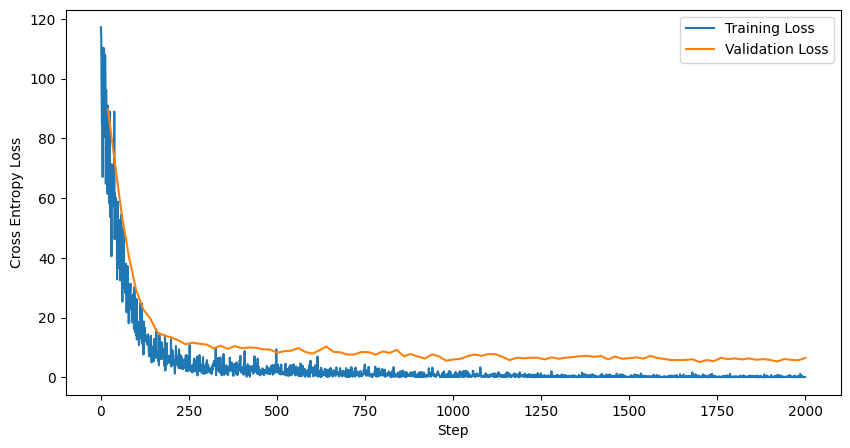

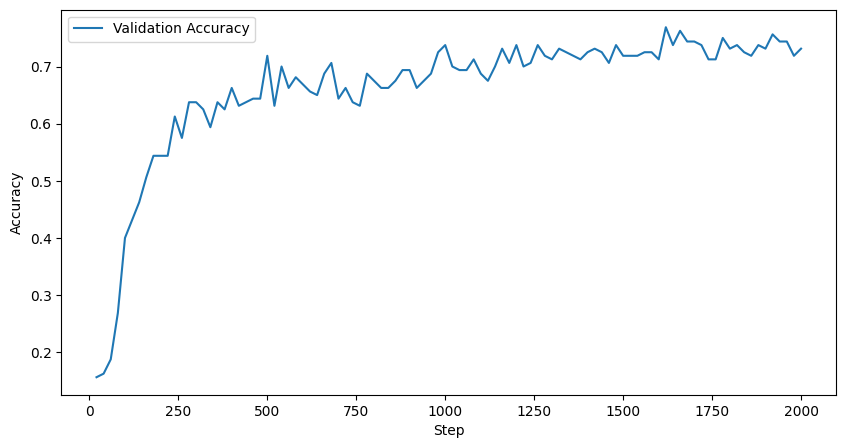

In [45]:
gtzan_train_loader, gtzan_val_loader = generate_gtzan_loaders(audio_tensors, genres, references_sample_rate, batch_size=32, mask_prob=0.8)

# Train the classifier
embeddings_model = GTZANContrastiveModelLarge
classification_model = ContrastiveClassificationModel_3
num_classes = len(audio_tensors)
batch_size = 128
contrastive_learning_rate = 0.001
classifier_learning_rate = 0.001
epochs = 100
output_dir = contrastive_output_dir

t_loss_history, v_loss_history, v_acc_history = train_classifier(embeddings_model, classification_model, num_classes,  gtzan_train_loader, gtzan_val_loader, epochs, classifier_learning_rate, contrastive_learning_rate, batch_size, output_dir)

plot_classifier_losses_accuracy(t_loss_history, v_loss_history, v_acc_history)


100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Epoch 1/100 | Train Loss: 676.4514 | Val Loss: 771.1605 | Val Acc: 0.1125


100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


Epoch 2/100 | Train Loss: 533.2127 | Val Loss: 643.2045 | Val Acc: 0.1813


100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Epoch 3/100 | Train Loss: 487.4870 | Val Loss: 523.7496 | Val Acc: 0.1875


100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Epoch 4/100 | Train Loss: 266.1516 | Val Loss: 420.2405 | Val Acc: 0.2625


100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


Epoch 5/100 | Train Loss: 282.6432 | Val Loss: 304.0706 | Val Acc: 0.3125


100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Epoch 6/100 | Train Loss: 130.8373 | Val Loss: 233.2150 | Val Acc: 0.4000


100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Epoch 7/100 | Train Loss: 165.3165 | Val Loss: 209.5027 | Val Acc: 0.4812


100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


Epoch 8/100 | Train Loss: 74.0819 | Val Loss: 177.2608 | Val Acc: 0.5250


100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Epoch 9/100 | Train Loss: 98.5151 | Val Loss: 151.3479 | Val Acc: 0.5562


100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Epoch 10/100 | Train Loss: 112.3720 | Val Loss: 136.6171 | Val Acc: 0.6000


100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Epoch 11/100 | Train Loss: 25.1460 | Val Loss: 130.7556 | Val Acc: 0.5312


100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Epoch 12/100 | Train Loss: 101.4316 | Val Loss: 125.5513 | Val Acc: 0.5625


100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Epoch 13/100 | Train Loss: 52.8597 | Val Loss: 132.9077 | Val Acc: 0.5437


100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Epoch 14/100 | Train Loss: 34.5617 | Val Loss: 112.3992 | Val Acc: 0.6000


100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Epoch 15/100 | Train Loss: 42.2704 | Val Loss: 111.9754 | Val Acc: 0.5750


100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Epoch 16/100 | Train Loss: 53.1336 | Val Loss: 114.9476 | Val Acc: 0.6125


100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


Epoch 17/100 | Train Loss: 55.4947 | Val Loss: 120.7284 | Val Acc: 0.5688


100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Epoch 18/100 | Train Loss: 31.9728 | Val Loss: 103.9806 | Val Acc: 0.6438


100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


Epoch 19/100 | Train Loss: 49.6320 | Val Loss: 114.7241 | Val Acc: 0.6062


100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


Epoch 20/100 | Train Loss: 44.4997 | Val Loss: 129.9640 | Val Acc: 0.6250


100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Epoch 21/100 | Train Loss: 32.0722 | Val Loss: 133.9614 | Val Acc: 0.5813


100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Epoch 22/100 | Train Loss: 58.4612 | Val Loss: 101.6365 | Val Acc: 0.5813


100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Epoch 23/100 | Train Loss: 60.7801 | Val Loss: 134.9667 | Val Acc: 0.6000


100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Epoch 24/100 | Train Loss: 10.7340 | Val Loss: 124.7318 | Val Acc: 0.6062


100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Epoch 25/100 | Train Loss: 32.4480 | Val Loss: 107.5405 | Val Acc: 0.6687


100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Epoch 26/100 | Train Loss: 15.2462 | Val Loss: 117.0937 | Val Acc: 0.6313


100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Epoch 27/100 | Train Loss: 44.1575 | Val Loss: 114.5519 | Val Acc: 0.6875


100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Epoch 28/100 | Train Loss: 14.1984 | Val Loss: 140.6007 | Val Acc: 0.5875


100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Epoch 29/100 | Train Loss: 35.1567 | Val Loss: 98.9038 | Val Acc: 0.6438


100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


Epoch 30/100 | Train Loss: 57.7666 | Val Loss: 105.9022 | Val Acc: 0.6250


100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


Epoch 31/100 | Train Loss: 37.6449 | Val Loss: 135.1466 | Val Acc: 0.5938


100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


Epoch 32/100 | Train Loss: 3.2641 | Val Loss: 123.8161 | Val Acc: 0.6375


100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Epoch 33/100 | Train Loss: 11.5622 | Val Loss: 126.6543 | Val Acc: 0.6375


100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


Epoch 34/100 | Train Loss: 41.4096 | Val Loss: 129.5034 | Val Acc: 0.6625


100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Epoch 35/100 | Train Loss: 23.8316 | Val Loss: 110.9302 | Val Acc: 0.6687


100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Epoch 36/100 | Train Loss: 48.9173 | Val Loss: 100.3918 | Val Acc: 0.6687


100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


Epoch 37/100 | Train Loss: 33.2312 | Val Loss: 122.3186 | Val Acc: 0.6562


100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


Epoch 38/100 | Train Loss: 34.7655 | Val Loss: 131.6582 | Val Acc: 0.6625


100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


Epoch 39/100 | Train Loss: 25.8883 | Val Loss: 115.3318 | Val Acc: 0.6875


100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Epoch 40/100 | Train Loss: 26.0209 | Val Loss: 108.4950 | Val Acc: 0.6875


100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Epoch 41/100 | Train Loss: 15.3200 | Val Loss: 108.5020 | Val Acc: 0.6562


100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Epoch 42/100 | Train Loss: 18.7210 | Val Loss: 120.8937 | Val Acc: 0.6750


100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Epoch 43/100 | Train Loss: 59.0336 | Val Loss: 130.8977 | Val Acc: 0.6438


100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Epoch 44/100 | Train Loss: 7.7953 | Val Loss: 102.7922 | Val Acc: 0.6562


100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Epoch 45/100 | Train Loss: 53.3806 | Val Loss: 114.4633 | Val Acc: 0.6375


100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Epoch 46/100 | Train Loss: 20.9888 | Val Loss: 100.9485 | Val Acc: 0.6750


100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Epoch 47/100 | Train Loss: 14.7826 | Val Loss: 106.5652 | Val Acc: 0.7000


100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Epoch 48/100 | Train Loss: 23.7286 | Val Loss: 105.2931 | Val Acc: 0.7063


100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


Epoch 49/100 | Train Loss: 24.5544 | Val Loss: 104.1387 | Val Acc: 0.7188


100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Epoch 50/100 | Train Loss: 29.2673 | Val Loss: 130.0088 | Val Acc: 0.6812


100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Epoch 51/100 | Train Loss: 17.8736 | Val Loss: 103.1654 | Val Acc: 0.6687


100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Epoch 52/100 | Train Loss: 27.1260 | Val Loss: 99.1997 | Val Acc: 0.6500


100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Epoch 53/100 | Train Loss: 11.0360 | Val Loss: 99.9288 | Val Acc: 0.7063


100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Epoch 54/100 | Train Loss: 22.7800 | Val Loss: 113.8349 | Val Acc: 0.6750


100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


Epoch 55/100 | Train Loss: 29.6541 | Val Loss: 113.7233 | Val Acc: 0.6750


100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


Epoch 56/100 | Train Loss: 39.5783 | Val Loss: 106.2394 | Val Acc: 0.6500


100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Epoch 57/100 | Train Loss: 16.4306 | Val Loss: 99.4271 | Val Acc: 0.7000


100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Epoch 58/100 | Train Loss: 12.3726 | Val Loss: 92.8211 | Val Acc: 0.6812


100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


Epoch 59/100 | Train Loss: 7.7562 | Val Loss: 115.3868 | Val Acc: 0.6625


100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Epoch 60/100 | Train Loss: 12.8960 | Val Loss: 119.4197 | Val Acc: 0.6812


100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Epoch 61/100 | Train Loss: 1.9596 | Val Loss: 91.7269 | Val Acc: 0.7063


100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


Epoch 62/100 | Train Loss: 19.2187 | Val Loss: 109.8228 | Val Acc: 0.7063


100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Epoch 63/100 | Train Loss: 10.1742 | Val Loss: 84.0722 | Val Acc: 0.7312


100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Epoch 64/100 | Train Loss: 59.5657 | Val Loss: 95.1252 | Val Acc: 0.7063


100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Epoch 65/100 | Train Loss: 10.8814 | Val Loss: 92.8241 | Val Acc: 0.7063


100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Epoch 66/100 | Train Loss: 10.4670 | Val Loss: 83.9177 | Val Acc: 0.7188


100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Epoch 67/100 | Train Loss: 19.4157 | Val Loss: 83.8993 | Val Acc: 0.7250


100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Epoch 68/100 | Train Loss: 4.7850 | Val Loss: 80.5491 | Val Acc: 0.7125


100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


Epoch 69/100 | Train Loss: 11.3776 | Val Loss: 87.8994 | Val Acc: 0.7000


100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


Epoch 70/100 | Train Loss: 14.9456 | Val Loss: 77.6503 | Val Acc: 0.7063


100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Epoch 71/100 | Train Loss: 0.8649 | Val Loss: 100.3803 | Val Acc: 0.6938


100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Epoch 72/100 | Train Loss: 8.4836 | Val Loss: 91.0304 | Val Acc: 0.6625


100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Epoch 73/100 | Train Loss: 18.6657 | Val Loss: 90.5086 | Val Acc: 0.7125


100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Epoch 74/100 | Train Loss: 0.0000 | Val Loss: 92.0138 | Val Acc: 0.7063


100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Epoch 75/100 | Train Loss: 7.5083 | Val Loss: 86.7549 | Val Acc: 0.7000


100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Epoch 76/100 | Train Loss: 0.7570 | Val Loss: 85.5498 | Val Acc: 0.7000


100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


Epoch 77/100 | Train Loss: 7.5961 | Val Loss: 85.8811 | Val Acc: 0.7063


100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Epoch 78/100 | Train Loss: 3.8637 | Val Loss: 93.0006 | Val Acc: 0.7000


100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Epoch 79/100 | Train Loss: 10.9827 | Val Loss: 75.5796 | Val Acc: 0.7312


100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


Epoch 80/100 | Train Loss: 0.0000 | Val Loss: 98.0745 | Val Acc: 0.7063


100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Epoch 81/100 | Train Loss: 0.9152 | Val Loss: 81.0916 | Val Acc: 0.7188


100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


Epoch 82/100 | Train Loss: 3.2078 | Val Loss: 88.8381 | Val Acc: 0.7000


100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Epoch 83/100 | Train Loss: 4.7440 | Val Loss: 83.4875 | Val Acc: 0.7063


100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Epoch 84/100 | Train Loss: 4.6522 | Val Loss: 78.0965 | Val Acc: 0.7125


100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Epoch 85/100 | Train Loss: 9.2077 | Val Loss: 83.6856 | Val Acc: 0.7000


100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Epoch 86/100 | Train Loss: 11.4979 | Val Loss: 78.8215 | Val Acc: 0.7125


100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


Epoch 87/100 | Train Loss: 0.0000 | Val Loss: 83.0545 | Val Acc: 0.7125


100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Epoch 88/100 | Train Loss: 3.6606 | Val Loss: 81.4969 | Val Acc: 0.7125


100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Epoch 89/100 | Train Loss: 7.9144 | Val Loss: 87.3107 | Val Acc: 0.7500


100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


Epoch 90/100 | Train Loss: 5.7035 | Val Loss: 78.8769 | Val Acc: 0.7000


100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


Epoch 91/100 | Train Loss: 0.1748 | Val Loss: 81.1478 | Val Acc: 0.7312


100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


Epoch 92/100 | Train Loss: 0.0000 | Val Loss: 89.2189 | Val Acc: 0.6875


100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


Epoch 93/100 | Train Loss: 0.0000 | Val Loss: 88.0080 | Val Acc: 0.6938


100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Epoch 94/100 | Train Loss: 0.6099 | Val Loss: 84.4663 | Val Acc: 0.7063


100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Epoch 95/100 | Train Loss: 5.1463 | Val Loss: 78.2880 | Val Acc: 0.7125


100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Epoch 96/100 | Train Loss: 0.0000 | Val Loss: 84.6542 | Val Acc: 0.6938


100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Epoch 97/100 | Train Loss: 0.0000 | Val Loss: 88.0061 | Val Acc: 0.7063


100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


Epoch 98/100 | Train Loss: 6.8656 | Val Loss: 80.3418 | Val Acc: 0.7125


100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Epoch 99/100 | Train Loss: 0.0000 | Val Loss: 78.2657 | Val Acc: 0.7375


100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Epoch 100/100 | Train Loss: 1.1335 | Val Loss: 78.4790 | Val Acc: 0.7188


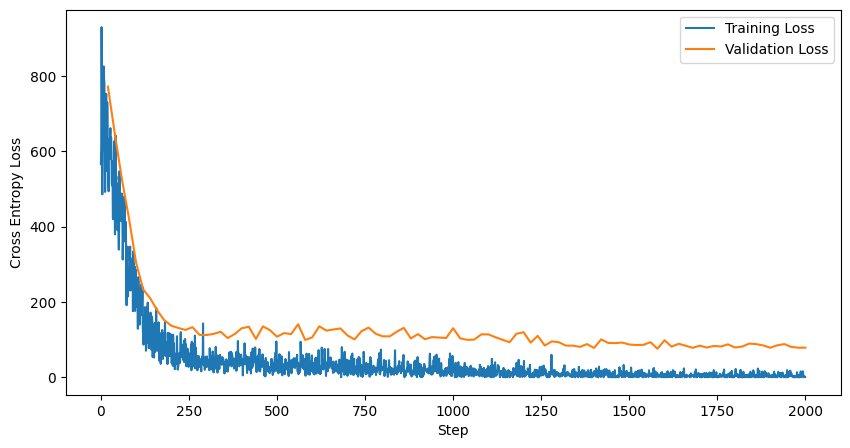

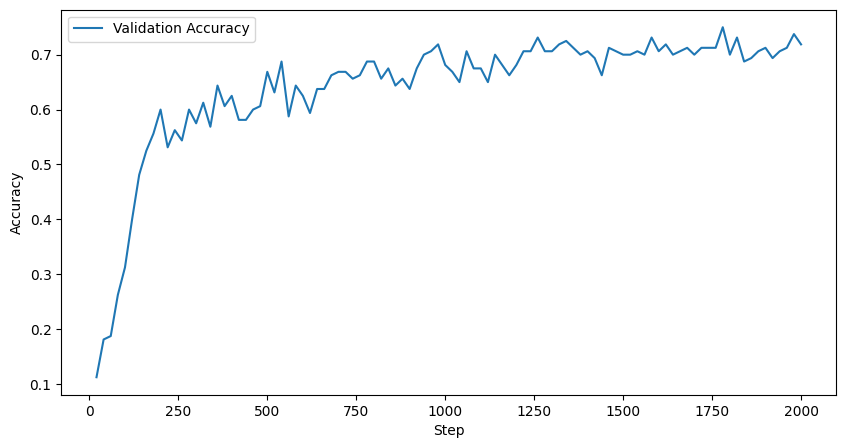

In [32]:
# Train the classifier
embeddings_model = GTZANContrastiveModelLarge
classification_model = ContrastiveClassificationModel_2
num_classes = len(audio_tensors)
embeddings_batch_size = 64
classifier_batch_size = 32
classifier_learning_rate = 0.001
embeddings_learning_rate = 0.001
epochs = 100
output_dir = contrastive_output_dir

gtzan_train_loader, gtzan_val_loader = generate_gtzan_loaders(audio_tensors, genres, references_sample_rate, batch_size=classifier_batch_size, mask_prob=0.8)

t_loss_history, v_loss_history, v_acc_history = train_classifier(embeddings_model, classification_model, num_classes,  gtzan_train_loader, gtzan_val_loader, epochs, embeddings_learning_rate, classifier_learning_rate, embeddings_batch_size,classifier_batch_size, output_dir)

plot_classifier_losses_accuracy(t_loss_history, v_loss_history, v_acc_history)

100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Epoch 1/200 | Train Loss: 164.7655 | Val Loss: 283.6676 | Val Acc: 0.0875


100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Epoch 2/200 | Train Loss: 176.9969 | Val Loss: 238.6334 | Val Acc: 0.0437


100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Epoch 3/200 | Train Loss: 155.6069 | Val Loss: 168.2637 | Val Acc: 0.0312


100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Epoch 4/200 | Train Loss: 150.5817 | Val Loss: 132.6116 | Val Acc: 0.0312


100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Epoch 5/200 | Train Loss: 143.7426 | Val Loss: 154.9773 | Val Acc: 0.0500


100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Epoch 6/200 | Train Loss: 153.6024 | Val Loss: 149.5410 | Val Acc: 0.0688


100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Epoch 7/200 | Train Loss: 118.7955 | Val Loss: 142.3416 | Val Acc: 0.0750


100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Epoch 8/200 | Train Loss: 116.3640 | Val Loss: 140.2752 | Val Acc: 0.0875


100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Epoch 9/200 | Train Loss: 219.9759 | Val Loss: 137.2116 | Val Acc: 0.1063


100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Epoch 10/200 | Train Loss: 72.5578 | Val Loss: 115.2042 | Val Acc: 0.0938


100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Epoch 11/200 | Train Loss: 134.1304 | Val Loss: 124.2484 | Val Acc: 0.1000


100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Epoch 12/200 | Train Loss: 104.7676 | Val Loss: 121.1485 | Val Acc: 0.1000


100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Epoch 13/200 | Train Loss: 78.4021 | Val Loss: 109.9951 | Val Acc: 0.0812


100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


Epoch 14/200 | Train Loss: 127.2482 | Val Loss: 103.2507 | Val Acc: 0.0938


100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Epoch 15/200 | Train Loss: 80.3418 | Val Loss: 94.2877 | Val Acc: 0.1250


100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Epoch 16/200 | Train Loss: 113.3723 | Val Loss: 86.7235 | Val Acc: 0.1688


100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


Epoch 17/200 | Train Loss: 74.9842 | Val Loss: 86.4415 | Val Acc: 0.1375


100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


Epoch 18/200 | Train Loss: 107.4716 | Val Loss: 77.0926 | Val Acc: 0.1500


100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


Epoch 19/200 | Train Loss: 70.6159 | Val Loss: 72.6918 | Val Acc: 0.1562


100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Epoch 20/200 | Train Loss: 79.8115 | Val Loss: 68.0451 | Val Acc: 0.1750


100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Epoch 21/200 | Train Loss: 45.6592 | Val Loss: 64.5306 | Val Acc: 0.1688


100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Epoch 22/200 | Train Loss: 48.6462 | Val Loss: 57.0692 | Val Acc: 0.2438


100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Epoch 23/200 | Train Loss: 50.3122 | Val Loss: 49.6922 | Val Acc: 0.2375


100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Epoch 24/200 | Train Loss: 58.6899 | Val Loss: 49.1722 | Val Acc: 0.2562


100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Epoch 25/200 | Train Loss: 47.2289 | Val Loss: 47.0692 | Val Acc: 0.3125


100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Epoch 26/200 | Train Loss: 59.4093 | Val Loss: 47.0450 | Val Acc: 0.2688


100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Epoch 27/200 | Train Loss: 56.8901 | Val Loss: 43.9919 | Val Acc: 0.3750


100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Epoch 28/200 | Train Loss: 34.4500 | Val Loss: 36.2810 | Val Acc: 0.3938


100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Epoch 29/200 | Train Loss: 35.2918 | Val Loss: 38.1712 | Val Acc: 0.3500


100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Epoch 30/200 | Train Loss: 68.5375 | Val Loss: 32.4462 | Val Acc: 0.3875


100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Epoch 31/200 | Train Loss: 58.5401 | Val Loss: 34.3175 | Val Acc: 0.3625


100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Epoch 32/200 | Train Loss: 27.2986 | Val Loss: 35.5332 | Val Acc: 0.3938


100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Epoch 33/200 | Train Loss: 34.3620 | Val Loss: 32.3316 | Val Acc: 0.4062


100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Epoch 34/200 | Train Loss: 31.2754 | Val Loss: 30.3689 | Val Acc: 0.4250


100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Epoch 35/200 | Train Loss: 25.6372 | Val Loss: 29.6344 | Val Acc: 0.3938


100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


Epoch 36/200 | Train Loss: 23.2259 | Val Loss: 29.3356 | Val Acc: 0.4500


100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Epoch 37/200 | Train Loss: 27.1343 | Val Loss: 27.8962 | Val Acc: 0.4000


100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Epoch 38/200 | Train Loss: 25.6246 | Val Loss: 24.9189 | Val Acc: 0.4375


100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Epoch 39/200 | Train Loss: 34.2798 | Val Loss: 22.7739 | Val Acc: 0.4750


100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Epoch 40/200 | Train Loss: 27.4665 | Val Loss: 22.6253 | Val Acc: 0.5000


100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Epoch 41/200 | Train Loss: 37.9428 | Val Loss: 22.0054 | Val Acc: 0.5125


100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Epoch 42/200 | Train Loss: 27.1560 | Val Loss: 22.3696 | Val Acc: 0.4812


100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Epoch 43/200 | Train Loss: 17.4772 | Val Loss: 20.0536 | Val Acc: 0.4625


100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Epoch 44/200 | Train Loss: 25.9431 | Val Loss: 17.9891 | Val Acc: 0.4875


100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Epoch 45/200 | Train Loss: 22.8184 | Val Loss: 19.7869 | Val Acc: 0.5000


100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Epoch 46/200 | Train Loss: 22.4848 | Val Loss: 21.3356 | Val Acc: 0.4750


100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


Epoch 47/200 | Train Loss: 31.6315 | Val Loss: 19.3046 | Val Acc: 0.4938


100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Epoch 48/200 | Train Loss: 23.9911 | Val Loss: 19.8105 | Val Acc: 0.5000


100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Epoch 49/200 | Train Loss: 15.8559 | Val Loss: 19.8113 | Val Acc: 0.4812


100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


Epoch 50/200 | Train Loss: 20.5188 | Val Loss: 18.4840 | Val Acc: 0.4938


100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Epoch 51/200 | Train Loss: 20.7275 | Val Loss: 20.4323 | Val Acc: 0.4875


100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Epoch 52/200 | Train Loss: 16.4306 | Val Loss: 19.5557 | Val Acc: 0.4500


100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Epoch 53/200 | Train Loss: 14.5778 | Val Loss: 18.3453 | Val Acc: 0.4625


100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Epoch 54/200 | Train Loss: 16.9459 | Val Loss: 15.4138 | Val Acc: 0.4812


100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Epoch 55/200 | Train Loss: 20.8695 | Val Loss: 17.4386 | Val Acc: 0.4938


100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Epoch 56/200 | Train Loss: 26.7451 | Val Loss: 19.2810 | Val Acc: 0.4938


100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


Epoch 57/200 | Train Loss: 19.6342 | Val Loss: 16.3105 | Val Acc: 0.5125


100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Epoch 58/200 | Train Loss: 11.0428 | Val Loss: 17.8534 | Val Acc: 0.4500


100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Epoch 59/200 | Train Loss: 4.7329 | Val Loss: 15.6421 | Val Acc: 0.4938


100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Epoch 60/200 | Train Loss: 17.7268 | Val Loss: 15.6824 | Val Acc: 0.5188


100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Epoch 61/200 | Train Loss: 18.7987 | Val Loss: 14.9083 | Val Acc: 0.5437


100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Epoch 62/200 | Train Loss: 17.6126 | Val Loss: 16.5479 | Val Acc: 0.4688


100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Epoch 63/200 | Train Loss: 17.2298 | Val Loss: 14.8404 | Val Acc: 0.5125


100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Epoch 64/200 | Train Loss: 37.9267 | Val Loss: 16.6939 | Val Acc: 0.5437


100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Epoch 65/200 | Train Loss: 19.1143 | Val Loss: 13.1687 | Val Acc: 0.5188


100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Epoch 66/200 | Train Loss: 15.9004 | Val Loss: 15.5150 | Val Acc: 0.5375


100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Epoch 67/200 | Train Loss: 10.7545 | Val Loss: 17.0263 | Val Acc: 0.5312


100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Epoch 68/200 | Train Loss: 16.9249 | Val Loss: 16.2122 | Val Acc: 0.5125


100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Epoch 69/200 | Train Loss: 9.4510 | Val Loss: 15.0766 | Val Acc: 0.4938


100%|██████████| 20/20 [00:01<00:00, 10.37it/s]


Epoch 70/200 | Train Loss: 10.3796 | Val Loss: 15.3726 | Val Acc: 0.5188


100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


Epoch 71/200 | Train Loss: 5.8080 | Val Loss: 13.1585 | Val Acc: 0.5437


100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Epoch 72/200 | Train Loss: 19.3456 | Val Loss: 15.7606 | Val Acc: 0.5125


100%|██████████| 20/20 [00:01<00:00, 10.35it/s]


Epoch 73/200 | Train Loss: 16.4459 | Val Loss: 13.6503 | Val Acc: 0.5437


100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


Epoch 74/200 | Train Loss: 11.7921 | Val Loss: 13.5498 | Val Acc: 0.5312


100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


Epoch 75/200 | Train Loss: 12.9635 | Val Loss: 14.7928 | Val Acc: 0.5437


100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


Epoch 76/200 | Train Loss: 16.6085 | Val Loss: 13.4209 | Val Acc: 0.5188


100%|██████████| 20/20 [00:01<00:00, 10.34it/s]


Epoch 77/200 | Train Loss: 15.1513 | Val Loss: 13.3711 | Val Acc: 0.5188


100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


Epoch 78/200 | Train Loss: 6.5660 | Val Loss: 14.5511 | Val Acc: 0.4938


100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Epoch 79/200 | Train Loss: 9.6220 | Val Loss: 13.3168 | Val Acc: 0.5562


100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


Epoch 80/200 | Train Loss: 8.0932 | Val Loss: 14.2953 | Val Acc: 0.5500


100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


Epoch 81/200 | Train Loss: 16.4372 | Val Loss: 13.0026 | Val Acc: 0.4938


100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Epoch 82/200 | Train Loss: 8.4082 | Val Loss: 13.0526 | Val Acc: 0.4875


100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Epoch 83/200 | Train Loss: 12.2367 | Val Loss: 13.6388 | Val Acc: 0.4688


100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Epoch 84/200 | Train Loss: 7.6053 | Val Loss: 12.0169 | Val Acc: 0.5437


100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Epoch 85/200 | Train Loss: 6.8533 | Val Loss: 13.0871 | Val Acc: 0.5188


100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Epoch 86/200 | Train Loss: 14.5243 | Val Loss: 12.8456 | Val Acc: 0.5000


100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


Epoch 87/200 | Train Loss: 5.7353 | Val Loss: 13.0239 | Val Acc: 0.5375


100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


Epoch 88/200 | Train Loss: 5.7573 | Val Loss: 11.9893 | Val Acc: 0.5000


100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Epoch 89/200 | Train Loss: 14.2410 | Val Loss: 11.9444 | Val Acc: 0.4938


100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Epoch 90/200 | Train Loss: 7.8719 | Val Loss: 12.1151 | Val Acc: 0.5125


100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


Epoch 91/200 | Train Loss: 16.1932 | Val Loss: 11.9486 | Val Acc: 0.5063


100%|██████████| 20/20 [00:01<00:00, 10.34it/s]


Epoch 92/200 | Train Loss: 13.7024 | Val Loss: 12.0480 | Val Acc: 0.5625


100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


Epoch 93/200 | Train Loss: 6.6007 | Val Loss: 11.9009 | Val Acc: 0.5562


100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Epoch 94/200 | Train Loss: 5.7269 | Val Loss: 13.3126 | Val Acc: 0.5000


100%|██████████| 20/20 [00:01<00:00, 10.33it/s]


Epoch 95/200 | Train Loss: 8.0149 | Val Loss: 10.7839 | Val Acc: 0.4812


100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Epoch 96/200 | Train Loss: 11.5916 | Val Loss: 11.2768 | Val Acc: 0.4938


100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


Epoch 97/200 | Train Loss: 12.2255 | Val Loss: 11.2652 | Val Acc: 0.5500


100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


Epoch 98/200 | Train Loss: 7.8804 | Val Loss: 10.8367 | Val Acc: 0.5063


100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


Epoch 99/200 | Train Loss: 9.9689 | Val Loss: 11.3851 | Val Acc: 0.5250


100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


Epoch 100/200 | Train Loss: 16.0197 | Val Loss: 13.0049 | Val Acc: 0.5125


100%|██████████| 20/20 [00:01<00:00, 10.36it/s]


Epoch 101/200 | Train Loss: 9.7652 | Val Loss: 9.9632 | Val Acc: 0.5437


100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


Epoch 102/200 | Train Loss: 10.1228 | Val Loss: 11.6085 | Val Acc: 0.5250


100%|██████████| 20/20 [00:01<00:00, 10.37it/s]


Epoch 103/200 | Train Loss: 5.3652 | Val Loss: 10.4710 | Val Acc: 0.5625


100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Epoch 104/200 | Train Loss: 6.7703 | Val Loss: 9.7504 | Val Acc: 0.5625


100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Epoch 105/200 | Train Loss: 7.3856 | Val Loss: 13.4823 | Val Acc: 0.5063


100%|██████████| 20/20 [00:01<00:00, 10.36it/s]


Epoch 106/200 | Train Loss: 8.0348 | Val Loss: 11.5646 | Val Acc: 0.5250


100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


Epoch 107/200 | Train Loss: 23.7116 | Val Loss: 11.1582 | Val Acc: 0.5562


100%|██████████| 20/20 [00:01<00:00, 10.33it/s]


Epoch 108/200 | Train Loss: 9.2044 | Val Loss: 13.0207 | Val Acc: 0.5188


100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


Epoch 109/200 | Train Loss: 6.2388 | Val Loss: 12.3395 | Val Acc: 0.5312


100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


Epoch 110/200 | Train Loss: 9.1035 | Val Loss: 12.7794 | Val Acc: 0.4812


100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


Epoch 111/200 | Train Loss: 9.6835 | Val Loss: 10.6578 | Val Acc: 0.5125


100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Epoch 112/200 | Train Loss: 8.0689 | Val Loss: 12.4682 | Val Acc: 0.5125


100%|██████████| 20/20 [00:01<00:00, 10.35it/s]


Epoch 113/200 | Train Loss: 9.1000 | Val Loss: 12.3587 | Val Acc: 0.4688


100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


Epoch 114/200 | Train Loss: 5.9882 | Val Loss: 10.6685 | Val Acc: 0.5500


100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Epoch 115/200 | Train Loss: 8.0498 | Val Loss: 13.0447 | Val Acc: 0.4750


100%|██████████| 20/20 [00:01<00:00, 10.39it/s]


Epoch 116/200 | Train Loss: 7.3571 | Val Loss: 11.0900 | Val Acc: 0.5250


100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Epoch 117/200 | Train Loss: 11.6563 | Val Loss: 11.8271 | Val Acc: 0.5312


100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


Epoch 118/200 | Train Loss: 4.0961 | Val Loss: 10.1047 | Val Acc: 0.5875


100%|██████████| 20/20 [00:01<00:00, 10.45it/s]


Epoch 119/200 | Train Loss: 11.3128 | Val Loss: 12.0955 | Val Acc: 0.5125


100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Epoch 120/200 | Train Loss: 7.1749 | Val Loss: 11.7364 | Val Acc: 0.5063


100%|██████████| 20/20 [00:01<00:00, 10.38it/s]


Epoch 121/200 | Train Loss: 4.7153 | Val Loss: 12.7900 | Val Acc: 0.5437


100%|██████████| 20/20 [00:01<00:00, 10.41it/s]


Epoch 122/200 | Train Loss: 7.1896 | Val Loss: 12.0555 | Val Acc: 0.5063


100%|██████████| 20/20 [00:01<00:00, 10.41it/s]


Epoch 123/200 | Train Loss: 6.5328 | Val Loss: 10.9774 | Val Acc: 0.4688


100%|██████████| 20/20 [00:01<00:00, 10.43it/s]


Epoch 124/200 | Train Loss: 12.4477 | Val Loss: 10.8496 | Val Acc: 0.5000


100%|██████████| 20/20 [00:01<00:00, 10.41it/s]


Epoch 125/200 | Train Loss: 8.3083 | Val Loss: 11.0121 | Val Acc: 0.4625


100%|██████████| 20/20 [00:01<00:00, 10.37it/s]


Epoch 126/200 | Train Loss: 11.1722 | Val Loss: 10.0799 | Val Acc: 0.5562


100%|██████████| 20/20 [00:01<00:00, 10.44it/s]


Epoch 127/200 | Train Loss: 5.2910 | Val Loss: 10.1650 | Val Acc: 0.5375


100%|██████████| 20/20 [00:01<00:00, 10.44it/s]


Epoch 128/200 | Train Loss: 6.2474 | Val Loss: 11.2102 | Val Acc: 0.5437


100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


Epoch 129/200 | Train Loss: 5.4431 | Val Loss: 10.8934 | Val Acc: 0.5625


100%|██████████| 20/20 [00:01<00:00, 10.44it/s]


Epoch 130/200 | Train Loss: 6.0861 | Val Loss: 11.4095 | Val Acc: 0.5125


100%|██████████| 20/20 [00:01<00:00, 10.48it/s]


Epoch 131/200 | Train Loss: 4.0550 | Val Loss: 12.3339 | Val Acc: 0.4750


100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


Epoch 132/200 | Train Loss: 7.5988 | Val Loss: 9.6864 | Val Acc: 0.5437


100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Epoch 133/200 | Train Loss: 8.4664 | Val Loss: 10.6117 | Val Acc: 0.5437


100%|██████████| 20/20 [00:01<00:00, 10.42it/s]


Epoch 134/200 | Train Loss: 7.3487 | Val Loss: 10.1893 | Val Acc: 0.5312


100%|██████████| 20/20 [00:01<00:00, 10.46it/s]


Epoch 135/200 | Train Loss: 10.8061 | Val Loss: 10.6798 | Val Acc: 0.4938


100%|██████████| 20/20 [00:01<00:00, 10.39it/s]


Epoch 136/200 | Train Loss: 10.6547 | Val Loss: 9.2036 | Val Acc: 0.5125


100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Epoch 137/200 | Train Loss: 6.8752 | Val Loss: 9.9449 | Val Acc: 0.5188


100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Epoch 138/200 | Train Loss: 5.2374 | Val Loss: 10.7937 | Val Acc: 0.5375


100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Epoch 139/200 | Train Loss: 7.2800 | Val Loss: 10.9469 | Val Acc: 0.5188


100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Epoch 140/200 | Train Loss: 6.9661 | Val Loss: 11.3095 | Val Acc: 0.4938


100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Epoch 141/200 | Train Loss: 15.3980 | Val Loss: 9.8361 | Val Acc: 0.5562


100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Epoch 142/200 | Train Loss: 3.3835 | Val Loss: 12.1485 | Val Acc: 0.5312


100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Epoch 143/200 | Train Loss: 10.6378 | Val Loss: 9.7716 | Val Acc: 0.5188


100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Epoch 144/200 | Train Loss: 2.0743 | Val Loss: 10.3458 | Val Acc: 0.5562


100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Epoch 145/200 | Train Loss: 15.7440 | Val Loss: 11.1814 | Val Acc: 0.5063


100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Epoch 146/200 | Train Loss: 5.8448 | Val Loss: 9.7871 | Val Acc: 0.5250


100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Epoch 147/200 | Train Loss: 8.5759 | Val Loss: 10.7650 | Val Acc: 0.5000


100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Epoch 148/200 | Train Loss: 5.6029 | Val Loss: 10.1620 | Val Acc: 0.5188


100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Epoch 149/200 | Train Loss: 6.7436 | Val Loss: 9.5285 | Val Acc: 0.5125


100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Epoch 150/200 | Train Loss: 6.4960 | Val Loss: 9.2670 | Val Acc: 0.5625


100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Epoch 151/200 | Train Loss: 6.2344 | Val Loss: 9.8767 | Val Acc: 0.5938


100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


Epoch 152/200 | Train Loss: 9.3105 | Val Loss: 9.7108 | Val Acc: 0.5000


100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Epoch 153/200 | Train Loss: 7.0175 | Val Loss: 9.2159 | Val Acc: 0.5125


100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Epoch 154/200 | Train Loss: 2.6283 | Val Loss: 9.1120 | Val Acc: 0.5125


100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Epoch 155/200 | Train Loss: 4.2434 | Val Loss: 8.3607 | Val Acc: 0.5312


100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Epoch 156/200 | Train Loss: 5.4355 | Val Loss: 11.6108 | Val Acc: 0.5437


100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Epoch 157/200 | Train Loss: 5.1342 | Val Loss: 10.0738 | Val Acc: 0.5000


100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


Epoch 158/200 | Train Loss: 3.3206 | Val Loss: 11.4123 | Val Acc: 0.5250


100%|██████████| 20/20 [00:01<00:00, 10.33it/s]


Epoch 159/200 | Train Loss: 9.7103 | Val Loss: 11.0090 | Val Acc: 0.5250


100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


Epoch 160/200 | Train Loss: 6.4056 | Val Loss: 10.6500 | Val Acc: 0.4938


100%|██████████| 20/20 [00:01<00:00, 10.35it/s]


Epoch 161/200 | Train Loss: 3.1870 | Val Loss: 8.6369 | Val Acc: 0.5688


100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


Epoch 162/200 | Train Loss: 12.4294 | Val Loss: 9.3786 | Val Acc: 0.5125


100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Epoch 163/200 | Train Loss: 4.6179 | Val Loss: 9.2465 | Val Acc: 0.5750


100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


Epoch 164/200 | Train Loss: 8.5840 | Val Loss: 11.6168 | Val Acc: 0.5437


100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Epoch 165/200 | Train Loss: 6.3403 | Val Loss: 10.4731 | Val Acc: 0.5188


100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Epoch 166/200 | Train Loss: 9.2679 | Val Loss: 11.1828 | Val Acc: 0.5125


100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Epoch 167/200 | Train Loss: 11.6178 | Val Loss: 9.4699 | Val Acc: 0.5312


100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


Epoch 168/200 | Train Loss: 3.6194 | Val Loss: 10.5271 | Val Acc: 0.5063


100%|██████████| 20/20 [00:01<00:00, 10.33it/s]


Epoch 169/200 | Train Loss: 3.3325 | Val Loss: 10.6576 | Val Acc: 0.5312


100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


Epoch 170/200 | Train Loss: 6.1537 | Val Loss: 11.0694 | Val Acc: 0.5562


100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


Epoch 171/200 | Train Loss: 4.3113 | Val Loss: 9.0821 | Val Acc: 0.5312


100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


Epoch 172/200 | Train Loss: 3.9861 | Val Loss: 8.2186 | Val Acc: 0.5250


100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Epoch 173/200 | Train Loss: 4.7054 | Val Loss: 10.7275 | Val Acc: 0.5500


100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Epoch 174/200 | Train Loss: 3.7634 | Val Loss: 9.4408 | Val Acc: 0.5813


100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Epoch 175/200 | Train Loss: 10.1851 | Val Loss: 10.0752 | Val Acc: 0.5063


100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Epoch 176/200 | Train Loss: 4.7216 | Val Loss: 10.3775 | Val Acc: 0.5312


100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Epoch 177/200 | Train Loss: 5.7140 | Val Loss: 10.4086 | Val Acc: 0.5000


100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Epoch 178/200 | Train Loss: 5.6673 | Val Loss: 9.8214 | Val Acc: 0.5625


100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Epoch 179/200 | Train Loss: 10.6360 | Val Loss: 9.2993 | Val Acc: 0.5437


100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Epoch 180/200 | Train Loss: 6.1070 | Val Loss: 9.7184 | Val Acc: 0.5125


100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Epoch 181/200 | Train Loss: 3.5317 | Val Loss: 12.0936 | Val Acc: 0.4875


100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Epoch 182/200 | Train Loss: 10.7952 | Val Loss: 8.8800 | Val Acc: 0.5750


100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Epoch 183/200 | Train Loss: 7.5100 | Val Loss: 10.5018 | Val Acc: 0.5188


100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Epoch 184/200 | Train Loss: 5.4120 | Val Loss: 10.1802 | Val Acc: 0.5000


100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Epoch 185/200 | Train Loss: 14.1067 | Val Loss: 9.2762 | Val Acc: 0.5500


100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Epoch 186/200 | Train Loss: 5.6388 | Val Loss: 10.2824 | Val Acc: 0.5063


100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Epoch 187/200 | Train Loss: 4.2044 | Val Loss: 9.9964 | Val Acc: 0.5437


100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Epoch 188/200 | Train Loss: 5.2246 | Val Loss: 10.1009 | Val Acc: 0.5063


100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Epoch 189/200 | Train Loss: 9.1726 | Val Loss: 10.5895 | Val Acc: 0.5625


100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Epoch 190/200 | Train Loss: 6.3961 | Val Loss: 9.7321 | Val Acc: 0.4938


100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Epoch 191/200 | Train Loss: 11.2270 | Val Loss: 10.3845 | Val Acc: 0.5188


100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Epoch 192/200 | Train Loss: 6.2785 | Val Loss: 9.9144 | Val Acc: 0.4938


100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Epoch 193/200 | Train Loss: 8.0327 | Val Loss: 9.0132 | Val Acc: 0.5625


100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Epoch 194/200 | Train Loss: 7.8810 | Val Loss: 11.0864 | Val Acc: 0.5063


100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Epoch 195/200 | Train Loss: 7.4774 | Val Loss: 10.5514 | Val Acc: 0.5063


100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Epoch 196/200 | Train Loss: 3.9186 | Val Loss: 10.0702 | Val Acc: 0.4938


100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Epoch 197/200 | Train Loss: 6.6200 | Val Loss: 11.2168 | Val Acc: 0.5063


100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Epoch 198/200 | Train Loss: 2.3064 | Val Loss: 9.1400 | Val Acc: 0.5500


100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Epoch 199/200 | Train Loss: 3.6937 | Val Loss: 9.6355 | Val Acc: 0.5312


100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Epoch 200/200 | Train Loss: 4.0414 | Val Loss: 9.3532 | Val Acc: 0.5188


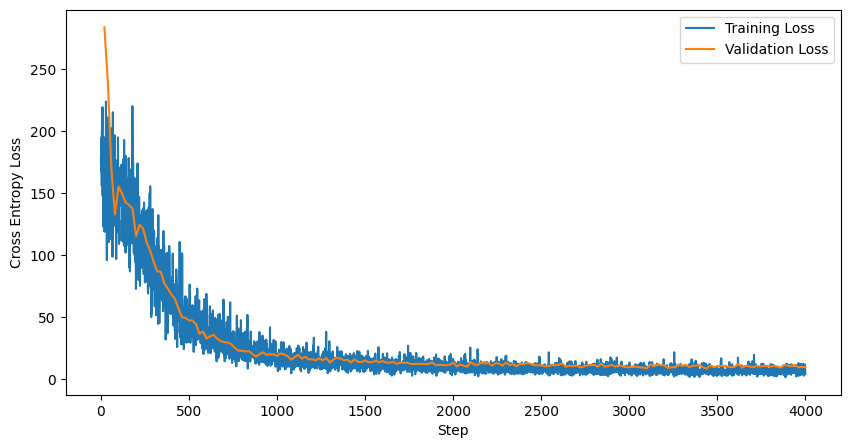

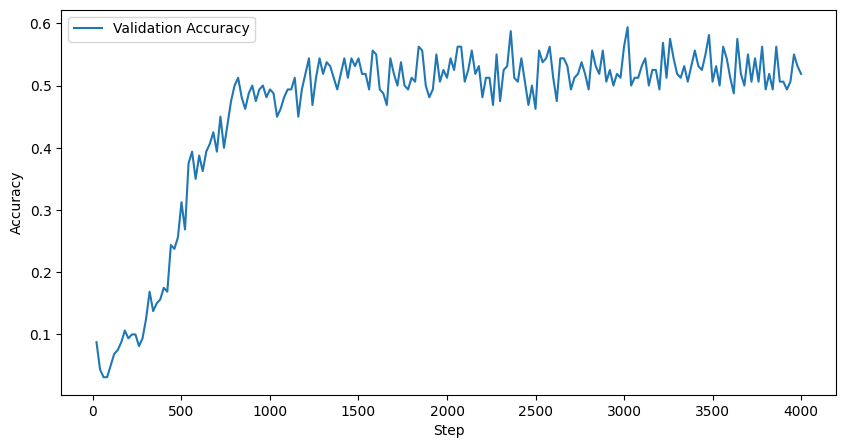

In [38]:
# Train the classifier
embeddings_model = GTZANContrastiveModelLarge
classification_model = ContrastiveClassificationModel_2
num_classes = len(audio_tensors)
embeddings_batch_size = 128
classifier_batch_size = 32
classifier_learning_rate = 0.0001
embeddings_learning_rate = 0.001
epochs = 200
output_dir = windows_ouput_dir / "contrastive"

gtzan_train_loader, gtzan_val_loader = generate_gtzan_loaders(audio_tensors, genres, references_sample_rate, batch_size=classifier_batch_size, mask_prob=0.8)

t_loss_history, v_loss_history, v_acc_history = train_classifier(embeddings_model, classification_model, num_classes,  gtzan_train_loader, gtzan_val_loader, epochs, embeddings_learning_rate, classifier_learning_rate, embeddings_batch_size,classifier_batch_size, output_dir)

plot_classifier_losses_accuracy(t_loss_history, v_loss_history, v_acc_history)

In [40]:
# Train the classifier
embeddings_model = GTZANContrastiveModelLarge
classification_model = ContrastiveClassificationModel
num_classes = len(audio_tensors)
embeddings_batch_size = 128
classifier_batch_size = 32
classifier_learning_rate = 0.001
embeddings_learning_rate = 0.001
epochs = 100
output_dir = windows_ouput_dir / "contrastive"

gtzan_train_loader, gtzan_val_loader = generate_gtzan_loaders(audio_tensors, genres, references_sample_rate, batch_size=classifier_batch_size, mask_prob=0.8)

t_loss_history, v_loss_history, v_acc_history = train_classifier(embeddings_model, classification_model, num_classes,  gtzan_train_loader, gtzan_val_loader, epochs, embeddings_learning_rate, classifier_learning_rate, embeddings_batch_size,classifier_batch_size, output_dir)

plot_classifier_losses_accuracy(t_loss_history, v_loss_history, v_acc_history)

  0%|          | 0/20 [00:00<?, ?it/s]


TypeError: cat() received an invalid combination of arguments - got (Tensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [ ]:
np.random.seed(SEED)
torch.manual_seed(SEED)

# Load the best contrastive embedding model
contrastive_embedder_model = GTZANContrastiveModelLarge(128)
contrastive_embedder_model.load_state_dict(torch.load(contrastive_output_dir / 'best.pth'))

# Check if the model already exists
if (contrastive_classifier_embedder_only_output_dir / 'best.pth').exists():
    res = input("Contrastive classifier (embeddings) model exists. Enter y to overwrite: ")
    if res.lower() != 'y':
        raise Exception("Model exists")

# Return to the original dataset to train the classifier
fold_generator = gtzan_generate_folds(audio_tensors, genres, references_sample_rate, mask_prob=0.8)
train_dataset, val_dataset = next(fold_generator)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

contrastive_classifier_embedder_only = ContrastiveClassificationModel_2(contrastive_embedder_model.backbone, len(audio_tensors), embedding_dim=1024)
contrastive_classifier_embedder_only = contrastive_classifier_embedder_only.to(device)
cont_emb_t_loss, cont_emb_v_loss, cont_emb_v_acc = train_base_gtzan_classifier(contrastive_classifier_embedder_only, train_loader, val_loader, epochs=100, learning_rate=0.001, output_dir=contrastive_classifier_embedder_only_output_dir)

In [ ]:
# Plot the loss and accuracy
contrastive_classifier_loss_fig, contrastive_classifier_loss_axs = plt.subplots(1, 1, figsize=(10, 5))
contrastive_classifier_loss_axs.plot(*zip(*cont_emb_t_loss), label='Training Loss')
contrastive_classifier_loss_axs.plot(*zip(*cont_emb_v_loss), label='Validation Loss')
contrastive_classifier_loss_axs.legend()
contrastive_classifier_loss_axs.set_xlabel('Step')
contrastive_classifier_loss_axs.set_ylabel('Cross Entropy Loss')
plt.show()

contrastive_classifier_acc_fig, contrastive_classifier_acc_axs = plt.subplots(1, 1, figsize=(10, 5))
contrastive_classifier_acc_axs.plot(*zip(*cont_emb_v_acc), label='Validation Accuracy')
contrastive_classifier_acc_axs.legend()
contrastive_classifier_acc_axs.set_xlabel('Step')
contrastive_classifier_acc_axs.set_ylabel('Accuracy')
plt.show()

In [ ]:
cont_acc = cont_v_acc[-1][1]
print(f"Average accuracy over folds: {cont_acc:.4f}")

In [ ]:
# Delete the classification models
del contrastive_classifier
del contrastive_classifier_embedder_only

# Clear the cache
if device == torch.device("cuda"):
    torch.cuda.empty_cache()
elif device == torch.device("mps"):
    torch.mps.empty_cache()

# Baseline Model
This section computes classical features for the songs and uses a random forest classifier to predict the genre.

The first step is to compute the features for each song.

In [ ]:
feature_tensors = {}
for i, genre in enumerate(genres):
    print(f"Computing features for {genre}")
    feature_tensors[genre_index_map[genre]] = []
    for waveform in tqdm(audio_tensors[i]):
        zcr = get_zero_crossing_rate(waveform, references_sample_rate)
        spectral_centroid = get_spectral_centroid(waveform, references_sample_rate)
        spectral_rolloff = get_spectral_rolloff(waveform, references_sample_rate)
        spectral_contrast = get_spectral_contrast(waveform, references_sample_rate)
        spectral_bandwidth = get_spectral_bandwidth(waveform, references_sample_rate)
        feature_tensors[genre_index_map[genre]].append({
            'zcr': zcr,
            'spectral_centroid': spectral_centroid,
            'spectral_rolloff': spectral_rolloff,
            'spectral_contrast': spectral_contrast,
            'spectral_bandwidth': spectral_bandwidth
        })

Then we use the raw timeseries that produces to compute summary statistics for each of the features.

In [ ]:
feature_stats_tensors = {}
for genre in genres:
    feature_stats_tensors[genre_index_map[genre]] = []
    for features in tqdm(feature_tensors[genre_index_map[genre]]):
        features_stats = {}
        for feature_name, feature in features.items():
            features_stats[feature_name] = (np.mean(feature), np.std(feature))
        feature_stats_tensors[genre_index_map[genre]].append(features_stats)

In [ ]:
def generate_feature_stats_folds(feature_stats_tensor, genres, k_folds=5):
    """
    Defines a generator that yields train and val datasets for each fold.
    """
    # First, we get a single list that includes all tensors
    X = []
    y = []
    for genre in genres:
        genre_index = genre_index_map[genre]
        for feature_stats in feature_stats_tensor[genre_index]:
            stats_order = ['zcr', 'spectral_centroid', 'spectral_rolloff', 'spectral_contrast', 'spectral_bandwidth']
            X.append([feature for stat in stats_order for feature in feature_stats[stat]])
            y.append(genre_index)

    X = np.array(X)
    y = np.array(y)

    # Then we can use the labels to perform a stratified k-fold split
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    for train_index, val_index in skf.split(X, y):
        t_X = X[train_index]
        t_y = y[train_index]
        v_X = X[val_index]
        v_y = y[val_index]
        yield t_X, t_y, v_X, v_y


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

accuracies = []

for t_X, t_y, v_X, v_y in generate_feature_stats_folds(feature_stats_tensors, genres, k_folds=5):
    print(f"Training on {len(t_X)} samples and validating on {len(v_X)} samples")
    clf = RandomForestClassifier(n_estimators=100, random_state=4)
    clf.fit(t_X, t_y)
    y_pred = clf.predict(v_X)
    acc = accuracy_score(v_y, y_pred)
    accuracies.append(acc)

    # Save the model
    model_output_dir = baseline_random_forest_output_dir / f"fold_{len(accuracies)}"
    model_output_dir.mkdir(exist_ok=True)

    model_output_file = model_output_dir / 'model.pkl'
    with open(model_output_file, 'wb') as f:
        pickle.dump(clf, f)

In [ ]:
avg_rf_acc = np.mean(accuracies)
std_rf_acc = np.std(accuracies)
print(f"Average accuracy over folds: {avg_rf_acc:.4f} +/- {std_rf_acc:.4f}")

# Baseline Model Applied to Contrastive Embeddings
Classical classification algorithms often outperform MLP models when taking embeddings from autoencoders or contrastive models. Along with training MLPs on the outputs of the contrastive model, we also train a random forest classifier on the logits from the contrastive model.

In [ ]:
# We also do the same thing with the contrastive model. Here we split the waveform into 10s windows and evaluate the contrastive model over each.
# We save the embeddings for each window in a tuple so that the embeddings from the same song are grouped together.
# Load the best contrastive embedding model
contrastive_embedder_model = GTZANContrastiveModelLarge(128)
contrastive_embedder_model.to(device)
contrastive_embedder_model.load_state_dict(torch.load(contrastive_output_dir / 'best.pth'))
contrastive_embedder_model.eval()

with torch.no_grad():
    contrastive_embeddings = {}
    for i, genre in enumerate(genres):
        print(f"Computing features for {genre}")
        contrastive_embeddings[genre_index_map[genre]] = []
        for waveform in tqdm(audio_tensors[i]):
            # Split the waveform into 10s windows
            window_length = 10 * references_sample_rate
            batch = []
            for end in range(window_length, waveform.shape[1], references_sample_rate):
                start = end - window_length
                window = waveform[:, start:end]

                mel_spectrogram = get_mel_spectrogram(window, references_sample_rate)

                batch.append(mel_spectrogram)
            # Convert the batch to a tensor on the device
            batch = torch.stack(batch).to(device)
            # Pass the batch through the model
            embeddings = contrastive_embedder_model.backbone(batch)
            # Move embeddings to the cpu
            contrastive_embeddings[genre_index_map[genre]].append(embeddings.cpu())

            # Delete tensors to free GPU memory
            del batch
            del embeddings
            torch.cuda.empty_cache()

In [ ]:
# Plot the embeddings with colors corresponding to genres
# Use PCA to reduce the dimensionality of the embeddings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

# Concatenate the embeddings and the genre labels
X = []
y = []
for genre in genres:
    genre_index = genre_index_map[genre]
    for embeddings in contrastive_embeddings[genre_index]:
        X.append(embeddings.cpu().detach().numpy())
        y.append(genre_index)

y = np.concatenate([[y[i]] * X[i].shape[0] for i in range(len(X))])
X = np.concatenate(X, axis=0)

# Perform PCA and TSNE
X_pca = pca.fit_transform(X)
X_tsne = tsne.fit_transform(X)

In [ ]:
# Plot the PCA and TSNE embeddings
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

for genre in genres:
    genre_index = genre_index_map[genre]
    genre_mask = y == genre_index
    axs[0].scatter(X_pca[genre_mask, 0], X_pca[genre_mask, 1], label=genre, s=2, alpha=0.5)
    axs[1].scatter(X_tsne[genre_mask, 0], X_tsne[genre_mask, 1], label=genre, s=7)

axs[0].set_title('PCA Embeddings')
axs[1].set_title('TSNE Embeddings')
axs[0].legend()
axs[1].legend()
plt.show()

In [ ]:
# Construct the generator for the folds
def generate_contrastive_folds(contrastive_embeddings, genres, k_folds=5):
    """
    Defines a generator that yields train and val datasets for each fold.
    """
    X = []
    y = []
    for genre in genres:
        genre_index = genre_index_map[genre]
        for embeddings in contrastive_embeddings[genre_index]:
            X.append(embeddings)
            y.append(genre_index)

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    for train_index, val_index in skf.split(X, y):
        t_X = torch.cat([X[i] for i in train_index], dim=0)
        t_y = torch.cat([torch.tensor([y[i]] * X[i].shape[0]) for i in train_index], dim=0)
        v_X = torch.cat([X[i] for i in val_index], dim=0)
        v_y = torch.cat([torch.tensor([y[i]] * X[i].shape[0]) for i in val_index], dim=0)
        yield t_X, t_y, v_X, v_y

In [ ]:
# Test the contrastive fold generator
for t_X, t_y, v_X, v_y in generate_contrastive_folds(contrastive_embeddings, genres, k_folds=5):
    print(f"Training on {t_X.shape} samples and validating on {v_X.shape} samples")
    print(f"Training on {t_y.shape} samples and validating on {v_y.shape} samples")
    break

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Train the classifier on the contrastive embeddings
contrastive_accuracies = []
contrastive_confusion_matrices = []
for t_X, t_y, v_X, v_y in generate_contrastive_folds(contrastive_embeddings, genres, k_folds=5):
    print(f"Training on {t_X.shape} samples and validating on {v_X.shape} samples")
    clf = RandomForestClassifier(n_estimators=200, random_state=4)
    clf.fit(t_X.numpy(), t_y.numpy())
    y_pred = clf.predict(v_X.numpy())
    acc = accuracy_score(v_y.numpy(), y_pred)
    contrastive_accuracies.append(acc)
    contrastive_confusion_matrices.append(confusion_matrix(v_y.numpy(), y_pred))

    # Save the model
    model_output_dir = contrastive_random_forest_output_dir / f"fold_{len(contrastive_accuracies)}"
    model_output_dir.mkdir(exist_ok=True)

    model_output_file = model_output_dir / 'model.pkl'
    with open(model_output_file, 'wb') as f:
        pickle.dump(clf, f)

In [ ]:
# Plot the confusion matrix
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].matshow(contrastive_confusion_matrices[i])
    axs[i].set_xlabel('Predicted')
    if i == 0:
        axs[i].set_ylabel('True')
        axs[i].set_yticks(np.arange(len(genres)), genres)
    else:
        axs[i].set_yticks([])
    axs[i].set_xticks(np.arange(len(genres)), genres, rotation=90)
    
    

plt.show()

In [ ]:
# Compute the average accuracy and standard deviation
avg_contrastive_acc = np.mean(contrastive_accuracies)
std_contrastive_acc = np.std(contrastive_accuracies)
print(f"Average accuracy over folds: {avg_contrastive_acc:.4f} +/- {std_contrastive_acc:.4f}")

# Results

We selected out a test set when we first loaded the GTZAN dataset which has never been seen by any of the models and which was never used to tune any hyperparameters. We will now compute the accuracy for each of the models on this test set.

In [ ]:
def evaluate_model(model):
    """
    Evaluates a model that takes Mel spectrograms as input and returns
    a distribution over the genres.
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    model.eval()
    with torch.no_grad():
        test_losses = []
        test_accuracies = []


        for start_prop in np.linspace(0, 1, 11):
            gtzan_test_dataset = GTZANDataset(
                audio_tensors_test,
                genres,
                genre_index_map,
                references_sample_rate,
                mask_prob=0,
                randomize=False,
                start_prop=start_prop
            )
            test_loader = DataLoader(gtzan_test_dataset, batch_size=len(gtzan_test_dataset), shuffle=False)

            for (waveform, mel_spectrogram, label) in test_loader:
                mel_spectrogram = mel_spectrogram.to(device)
                label = label.to(device)

                output = model(mel_spectrogram)
                test_loss = criterion(output, label)
                test_losses.append(test_loss.item())
                test_acc = (output.argmax(dim=1) == label).float().mean()
                test_accuracies.append(test_acc.item())

            test_loss = torch.tensor(test_losses).mean()
            test_acc = torch.tensor(test_accuracies).mean()

    return test_loss, test_acc

First, we evaluate the end to end CNN that was trained on GTZAN. We expect that model to perform well as it is trained exclusively on other samples from the same dataset on which we are testing.

In [ ]:
def evaluate_baseline_deep_model():
    model = GTZANModel(len(audio_tensors))
    
    fold_folders = list(deep_base_output_dir.glob('fold_*'))
    losses = []
    accuracies = []
    for i, fold_folder in enumerate(fold_folders):
        model_path = fold_folder / 'best.pth'
        model.load_state_dict(torch.load(model_path))

        test_loss, test_acc = evaluate_model(model)
        losses.append(test_loss.item())
        accuracies.append(test_acc.item())

    loss_avg, loss_std = np.mean(losses), np.std(losses)
    acc_avg, acc_std = np.mean(accuracies), np.std(accuracies)
    return (loss_avg, loss_std), (acc_avg, acc_std)

baseline_deep_loss_stats, baseline_deep_acc_stats = evaluate_baseline_deep_model()
print(f"Baseline Deep Model Loss: {baseline_deep_loss_stats[0]:.4f} +/- {baseline_deep_loss_stats[1]:.4f}")
print(f"Baseline Deep Model Accuracy: {baseline_deep_acc_stats[0]:.4f} +/- {baseline_deep_acc_stats[1]:.4f}")

In [ ]:
def evaluate_contrastive_classifier_model():
    contrastive_embedder_model = GTZANContrastiveModelLarge(128)
    contrastive_classifier = ContrastiveClassificationModel(contrastive_embedder_model, len(audio_tensors))
    contrastive_classifier.load_state_dict(torch.load(contrastive_classifier_output_dir / 'best.pth'))

    test_loss, test_acc = evaluate_model(contrastive_classifier)
    return (test_loss, -1), (test_acc, -1)

contrastive_classifier_loss_stats, contrastive_classifier_acc_stats = evaluate_contrastive_classifier_model()
print(f"Contrastive Classifier Model Loss: {contrastive_classifier_loss_stats[0]:.4f}")
print(f"Contrastive Classifier Model Accuracy: {contrastive_classifier_acc_stats[0]:.4f}")


In [ ]:
def evaluate_contrastive_logit_classifier_model():
    contrastive_embedder_model = GTZANContrastiveModelLarge(128)
    contrastive_classifier_embedder_only = ContrastiveClassificationModel(contrastive_embedder_model.backbone, len(audio_tensors), embedding_dim=1024)
    contrastive_classifier_embedder_only.load_state_dict(torch.load(contrastive_classifier_embedder_only_output_dir / 'best.pth'))

    test_loss, test_acc = evaluate_model(contrastive_classifier_embedder_only)
    return (test_loss, -1), (test_acc, -1)

contrastive_logit_classifier_loss_stats, contrastive_logit_classifier_acc_stats = evaluate_contrastive_logit_classifier_model()
print(f"Contrastive Logit Classifier Model Loss: {contrastive_logit_classifier_loss_stats[0]:.4f}")
print(f"Contrastive Logit Classifier Model Accuracy: {contrastive_logit_classifier_acc_stats[0]:.4f}")

In [ ]:
def evaluate_classical_baseline_model():
    test_feature_tensors = {}
    for i, genre in enumerate(genres):
        print(f"Computing features for {genre}")
        test_feature_tensors[genre_index_map[genre]] = []
        for waveform in tqdm(audio_tensors_test[i]):
            zcr = get_zero_crossing_rate(waveform, references_sample_rate)
            spectral_centroid = get_spectral_centroid(waveform, references_sample_rate)
            spectral_rolloff = get_spectral_rolloff(waveform, references_sample_rate)
            spectral_contrast = get_spectral_contrast(waveform, references_sample_rate)
            spectral_bandwidth = get_spectral_bandwidth(waveform, references_sample_rate)
            test_feature_tensors[genre_index_map[genre]].append({
                'zcr': zcr,
                'spectral_centroid': spectral_centroid,
                'spectral_rolloff': spectral_rolloff,
                'spectral_contrast': spectral_contrast,
                'spectral_bandwidth': spectral_bandwidth
            })
    
    test_feature_stats_tensors = {}
    for genre in genres:
        test_feature_stats_tensors[genre_index_map[genre]] = []
        for features in tqdm(test_feature_tensors[genre_index_map[genre]]):
            features_stats = {}
            for feature_name, feature in features.items():
                features_stats[feature_name] = (np.mean(feature), np.std(feature))
            test_feature_stats_tensors[genre_index_map[genre]].append(features_stats)

    # Collect the tensors into an X and y array
    test_X = []
    test_y = []
    for genre in genres:
        genre_index = genre_index_map[genre]
        for feature_stats in test_feature_stats_tensors[genre_index]:
            stats_order = ['zcr', 'spectral_centroid', 'spectral_rolloff', 'spectral_contrast', 'spectral_bandwidth']
            test_X.append([feature for stat in stats_order for feature in feature_stats[stat]])
            test_y.append(genre_index)

    test_X = np.array(test_X)
    test_y = np.array(test_y)

    fold_folders = list(baseline_random_forest_output_dir.glob('fold_*'))
    accuracies = []

    for i, fold_folder in enumerate(fold_folders):
        model_path = fold_folder / 'model.pkl'
        with open(model_path, 'rb') as f:
            clf = pickle.load(f)
        y_pred = clf.predict(test_X)
        acc = accuracy_score(test_y, y_pred)
        accuracies.append(acc)
    
    accuracies = np.array(accuracies)
    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    return (-1, -1), (avg_acc, std_acc)

classical_baseline_loss_stats, classical_baseline_acc_stats = evaluate_classical_baseline_model()
print(f"Classical Baseline Model Loss: N/A")
print(f"Classical Baseline Model Accuracy: {classical_baseline_acc_stats[0]:.4f} +/- {classical_baseline_acc_stats[1]:.4f}")

In [ ]:
def evaluate_contrastive_rf_baseline_model():
    # Load the contrastive model
    contrastive_embedder_model = GTZANContrastiveModelLarge(128)
    contrastive_embedder_model.load_state_dict(torch.load(contrastive_output_dir / 'best.pth'))
    contrastive_embedder_model.to(device)
    contrastive_embedder_model.eval()

    fold_folders = list(contrastive_random_forest_output_dir.glob('fold_*'))
    accuracies = []

    with torch.no_grad():
        for i, fold_folder in enumerate(fold_folders):
            for start_prop in np.linspace(0, 1, 11):
                gtzan_test_dataset = GTZANDataset(
                    audio_tensors_test,
                    genres,
                    genre_index_map,
                    references_sample_rate,
                    mask_prob=0,
                    randomize=False,
                    start_prop=start_prop
                )
                test_loader = DataLoader(gtzan_test_dataset, batch_size=len(gtzan_test_dataset), shuffle=False)

                for (waveform, mel_spectrogram, label) in test_loader:
                    mel_spectrogram = mel_spectrogram.to(device)
                    embeddings = contrastive_embedder_model.backbone(mel_spectrogram)
                    embeddings = embeddings.cpu().detach().numpy()
                    label = label.numpy()

                    model_path = fold_folder / 'model.pkl'
                    with open(model_path, 'rb') as f:
                        clf = pickle.load(f)
                    y_pred = clf.predict(embeddings)
                    acc = accuracy_score(label, y_pred)
                    accuracies.append(acc)

    accuracies = np.array(accuracies)
    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    return (-1, -1), (avg_acc, std_acc)

contrastive_rf_baseline_loss_stats, contrastive_rf_baseline_acc_stats = evaluate_contrastive_rf_baseline_model()
print(f"Contrastive RF Baseline Model Loss: N/A")
print(f"Contrastive RF Baseline Model Accuracy: {contrastive_rf_baseline_acc_stats[0]:.4f} +/- {contrastive_rf_baseline_acc_stats[1]:.4f}")


In [ ]:
# Summary of all the test accuracies
print(f"Baseline Random Forest Test Accuracy: {100*classical_baseline_acc_stats[0]:.2f}% +/- {100*classical_baseline_acc_stats[1]:.2f}%")
print(f"Baseline CNN Test Accuracy: {100*baseline_deep_acc_stats[0]:.2f}% +/- {100*baseline_deep_acc_stats[1]:.2f}%")

print(f"MLP with contrastive embeddings Test Accuracy: {100*contrastive_classifier_acc_stats[0]:.2f}%")
print(f"MLP with contrastive logits Test Accuracy: {100*contrastive_logit_classifier_acc_stats[0]:.2f}%")

print(f"Random Forest with contrastive embeddings Test Accuracy: {100*contrastive_rf_baseline_acc_stats[0]:.2f}% +/- {100*contrastive_rf_baseline_acc_stats[1]:.2f}%")

For a further test, we would like to train both the baseline CNN and the random forest with contrastive embeddings with different numbers of training samples to see which is more robust to lower dataset sizes.